In [2]:
import pandas as pd
import numpy as np

#Plotting libraries and other types
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib import gridspec
from collections import Counter
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd


#Analytical libraries
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix

from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#Mute warning messages: If errors occur, hash-out this import
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

# Introductory remarks

This notebook is split into 5 main sections:

1. Data cleaning
2. Data exploration and visualization
3. Clustering
4. Supervised model performance and selection
    * 4.1. Modelling 'AGE' 
    * 4.2. Modelling 'STAGE'
    * 4.3. MLP approach
5. Concluding remarks
6. References

The data are from the Volve oilfield off the coast of southern Norway and recently decommisioned by the operator Equinor. Under an open-release programme, Equinor have made these data from multiple oil wells open-source and they cover many different types of operational and exploration data. Of interest here are the data from biostratigraphic analyses (fossils) that are represented in 13 different wells. 

There are no open-source publications that present analyses of such data types, that are highly important for oil exploration, and the purpose of this study is to determine __how well different machine learning approaches perform in classfying age of rock samples__.

First, the major time diversions of AGE are modelled to access workable souloutions. Second, the best approach is run on STAGE that are lower-order, and high-resolution divisions of ages and potentially less distinct.

### How were the data collected by the original consultants?

In this dataset, two consultancies generated the data and produced reports for Equinor (Statoil as it was previously know). Each consultancy has a different count technique although most will try and balance the proportion of marine phytoplankton with terrestrially derived pollen and spores. Some clients specify how they want data generated, such as Equinor, and other clients do not. Data were generated in the following ways according to the reports (.pdf) that are provided by the Volve open dataset:

#### BioStrat Ltd.
"The palynological counting procedure includes two separate counts; Count 1 includes 100 identifiable palynomorphs, including pollen, spores, microplankton, acritarchs and miscellaneous forms. Count 2 is of 100 marine taxa, miscellaneous microplankton and acritarchs, with further scanning for rare taxa."

#### Ichron Ltd.
"Palynological analysis utilized the Statoil counting technique that is based on a ‘double
count system’:

Count 1- (100 palynomorphs) describes the general (total) composition. In this count, all
palynomorphs are recorded at species or subspecies level. The total number of dinocyst
specimens recorded within this count is listed on the distribution chart as ‘Dinocysts
Count 1’.

Count 2- (100 dinocysts) describes the relative proportion of the dinocyst species.
Following on from Count 1, dinocysts are continued to be recorded so that the total
number of dinocyst specimens over both counts reaches 100. Once this has been reached
the slide is scanned for additional taxa."

__The data collected by both consultancies should be comparable. Differences will reside in taxonomic expertise of the consultants. You cannot correct for this easily without in-depth domain knowledge and 'best guess'.__

# 1. Data Cleaning

In [2]:
df = pd.read_csv('Volve_merged_raw.csv')
df.fillna(value=0, inplace=True)
df.head()

,depth,type,analyst,label,site,Araucariacidites_australis,Bisaccates_undiff.,Chlamydophorella_spp.,Cyathidites_spp.,Densoisporites_velatus,...,Palambages_spp.,Achomosphaera_cenomaniana,Inaperturopollenites_hiatus_.,Ovoidinium_verrucosum,Circulodinium_hystrix.distinctum_.,Systematophora_daveyi_.,Fromea_tornatilis_.,Classopollis_meyriana,Lycopodiacidites_rugulatus_.,Halosphaeropsis_liassica_.
0,3270.0,CU,BIOS,N15_9_F_01_01,F1,2,6,2,1,1,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
1,3276.0,CU,BIOS,N15_9_F_01_02,F1,2,24,0,1,0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
2,3282.0,CU,BIOS,N15_9_F_01_03,F1,1,20,1,2,0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
3,3288.0,CU,BIOS,N15_9_F_01_04,F1,1,26,+,3,0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
4,3294.0,CU,BIOS,N15_9_F_01_05,F1,2,24,0,4,0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0


In [140]:
df.columns

Index(['AGE', 'STAGE', 'FORMATION', 'ZONE', 'BASE', 'TYPE', 'ANALYST', 'SITE',
       'LABEL', 'N',
       ...
       'Lecaniella_cf._spongiose', 'leiosphere_.thick_walled.',
       'Tasmanites_sp._A', 'Glossodinium_dimorphum', 'Acanthomorph.acritarchs',
       'Bosedinia.spp.', 'Callialasporites.dampierii',
       'Dictyophyllidites.harrisii', 'Dinopterygium.cladoides',
       'fungal_spores.hyphae'],
      dtype='object', length=439)

In [4]:
#Columns to add. Code adapted from Petrou (2017)
new_columns = ['AGE',
               'STAGE',
               'FORMATION',
               'ZONE',
               'BASE', #Base depth in feet
               'TYPE',
               'ANALYST',
               'SITE',
               'LABEL'] 

def column_updates(new_columns,df):
    df_columns=df.columns
    new_columns=new_columns
    
    #Split off the original columns as a list
    other_columns = list(df_columns.values) 
    
    #Add the columns to the original df
    new_df = pd.concat([df,pd.DataFrame(columns=list(new_columns))], sort=False)
    
    #order the columns
    new_col_order = new_columns + other_columns
    set(new_df.columns)==set(new_col_order)
    x =new_df[new_col_order]
    return x


In [5]:
df = column_updates(new_columns, df)
df.head()

,AGE,STAGE,FORMATION,ZONE,BASE,TYPE,ANALYST,SITE,LABEL,depth,...,Palambages_spp.,Achomosphaera_cenomaniana,Inaperturopollenites_hiatus_.,Ovoidinium_verrucosum,Circulodinium_hystrix.distinctum_.,Systematophora_daveyi_.,Fromea_tornatilis_.,Classopollis_meyriana,Lycopodiacidites_rugulatus_.,Halosphaeropsis_liassica_.
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3270.0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3276.0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3282.0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3288.0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3294.0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0


In [6]:
##Reassign and relabel some existing column headings
df['BASE'] = df['depth']
df['ANALYST'] = df['analyst']
df['TYPE'] = df['type']
df['LABEL'] = df['label']
df['SITE'] = df['site']

df.tail()

,AGE,STAGE,FORMATION,ZONE,BASE,TYPE,ANALYST,SITE,LABEL,depth,...,Palambages_spp.,Achomosphaera_cenomaniana,Inaperturopollenites_hiatus_.,Ovoidinium_verrucosum,Circulodinium_hystrix.distinctum_.,Systematophora_daveyi_.,Fromea_tornatilis_.,Classopollis_meyriana,Lycopodiacidites_rugulatus_.,Halosphaeropsis_liassica_.
758,NaN,NaN,NaN,NaN,3770.0,CU,BIOS,F5,N15_9_F5_67,3770.0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
759,NaN,NaN,NaN,NaN,3776.0,CU,BIOS,F5,N15_9_F5_68,3776.0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
760,NaN,NaN,NaN,NaN,3782.0,CU,BIOS,F5,N15_9_F5_69,3782.0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
761,NaN,NaN,NaN,NaN,3788.0,CU,BIOS,F5,N15_9_F5_70,3788.0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
762,NaN,NaN,NaN,NaN,3792.0,CU,BIOS,F5,N15_9_F5_71,3792.0,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0


In [7]:
##Make a list of all of the columns in the df
#list(df.columns.values) 

##Reorganise columns so that duplicates and unwanted columns are removed.
df = df.drop(['depth', 'type','analyst','label','site'], axis=1)
df.head()


,AGE,STAGE,FORMATION,ZONE,BASE,TYPE,ANALYST,SITE,LABEL,Araucariacidites_australis,...,Palambages_spp.,Achomosphaera_cenomaniana,Inaperturopollenites_hiatus_.,Ovoidinium_verrucosum,Circulodinium_hystrix.distinctum_.,Systematophora_daveyi_.,Fromea_tornatilis_.,Classopollis_meyriana,Lycopodiacidites_rugulatus_.,Halosphaeropsis_liassica_.
0,NaN,NaN,NaN,NaN,3270.0,CU,BIOS,F1,N15_9_F_01_01,2,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
1,NaN,NaN,NaN,NaN,3276.0,CU,BIOS,F1,N15_9_F_01_02,2,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
2,NaN,NaN,NaN,NaN,3282.0,CU,BIOS,F1,N15_9_F_01_03,1,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
3,NaN,NaN,NaN,NaN,3288.0,CU,BIOS,F1,N15_9_F_01_04,1,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0
4,NaN,NaN,NaN,NaN,3294.0,CU,BIOS,F1,N15_9_F_01_05,2,...,0.0,0.0,0,0.0,0,0,0,0.0,0,0


In [11]:
##Check correct columns are removed. Result sows that cols[0:10] are the descriptors and labels and the rest are fossils.
list(df.columns.values[0:9])

['AGE',
 'STAGE',
 'FORMATION',
 'ZONE',
 'BASE',
 'TYPE',
 'ANALYST',
 'SITE',
 'LABEL']

In [12]:
#Make a list of all the different wells:
list(df.SITE.unique())
#df.to_csv('df.csv')

['F1',
 'F4',
 'F11A',
 'F11B',
 'F11T',
 'F12',
 'F14',
 'F15',
 'F15A',
 'F15B',
 'F1A',
 'F1B',
 'F5']

### Updates to individual wells

NOTE - if the update crashes, you may need to **resort the index** using df.sort_index(inplace=True)

Each well has other information associated with it from other .csv files. These include the following that form the labels and classes for this study:

* AGE - the geological age. A major subdivision in time (e.g. Early Cretaceous). These span many millions of years.
* STAGE - a subdivision of age. e.g. Bajocian, Callovian. These can span million of years
* ZONE - subdivions of time that are not universally defined (like geological ages and stages) but time bins characterized by associations of fossils.
* FORMATION - the geological rock unit name
* ANALYST - the name of the consultancy that generated the data.


In [13]:
#Make a copy of the df incase it goes wrong!:
df_raw = df

### F1

In [141]:
##Edit Analyst
df.loc[df['SITE'] == 'F1','ANALYST'] = 'BioStrat'

##Edit age and stage information

df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3270,3294)),'AGE'] = 'Early Cretaceous'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3300,3414)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3420,3632)),'AGE'] = 'Triassic?'

df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3270,3270)),'STAGE'] = 'Barremian?'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3276,3294)),'STAGE'] = 'Early Berriasian'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3300,3318)),'STAGE'] = 'Late Tithonian'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3324,3351)),'STAGE'] = 'Mid Oxfordian'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3354,3414)),'STAGE'] = 'Early?-Mid Oxfordian'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3420,3632)),'STAGE'] = 'Indet'

##Edit FORMATION information

df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3270,3320)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3320,3365)),'FORMATION'] = 'Heather'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3365,3500)),'FORMATION'] = 'Sleipner?'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3500,3632)),'FORMATION'] = 'Unassigned'

##Edit ZONE information

df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3270,3270)),'ZONE'] = 'Unassigned'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3276,3282)),'ZONE'] = 'EKZ2'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3288,3294)),'ZONE'] = 'EKZ1'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3300,3306)),'ZONE'] = 'JZ50b'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3312,3318)),'ZONE'] = 'JZ49b'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3324,3351)),'ZONE'] = 'JZ31'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3312,3318)),'ZONE'] = 'JZ49b'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3354,3402)),'ZONE'] = 'JZ30?-31'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3408,3414)),'ZONE'] = 'JZ30?-31?'
df.loc[(df['SITE'] == 'F1') & (df['BASE'].between(3420,3632)),'ZONE'] = 'Unassigned'


### F4

In [142]:
##Edit Analyst
df.loc[df['SITE'] == 'F4','ANALYST'] = 'BioStrat'

##Edit age and stage information

df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3090,3090)),'AGE'] = 'Late Cretaceous'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3110,3120)),'AGE'] = 'Early Cretaceous'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3130,3250)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3261,3507)),'AGE'] = 'Middle Jurassic'


df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3090,3090)),'STAGE'] = 'Late Cenomanian'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3110,3120)),'STAGE'] = 'Early Berriasian'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3130,3130)),'STAGE'] = 'Early Tithonian'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3140,3150)),'STAGE'] = 'Kimmeridgian'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3160,3190)),'STAGE'] = 'Late Oxfordian'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3200,3210)),'STAGE'] = 'Mid Oxfordian'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3220,3250)),'STAGE'] = 'Early Oxfordian'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3261,3294)),'STAGE'] = 'Late Callovian'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3297,3339)),'STAGE'] = 'Mid?-Late Callovian'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3342,3507)),'STAGE'] = 'Mid Callovian?'


##Edit FORMATION information

df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3065,3101)),'FORMATION'] = 'Aasgard'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3101,3190)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3190,3250)),'FORMATION'] = 'Heather'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3250,3430)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3430,3507)),'FORMATION'] = 'Sleipner'


##Edit ZONE information

df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3110,3120)),'ZONE'] = 'KZP1'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3130,3130)),'ZONE'] = 'JZP38-40a'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3140,3150)),'ZONE'] = 'JZP36'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3160,3160)),'ZONE'] = 'JZP31'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3170,3190)),'ZONE'] = 'JZP30-31'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3200,3210)),'ZONE'] = 'JZP28'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3220,3220)),'ZONE'] = 'JZP27'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3230,3240)),'ZONE'] = 'JZP26'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3261,3270)),'ZONE'] = 'JZP25'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3273,3294)),'ZONE'] = 'JZP24'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3297,3339)),'ZONE'] = 'JZP23?-24'
df.loc[(df['SITE'] == 'F4') & (df['BASE'].between(3342,3507)),'ZONE'] = 'JZP24'


### F11A

In [143]:
##Edit Analyst
df.loc[df['SITE'] == 'F11A','ANALYST'] = 'Ichron'

##Edit age and stage information

df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3529,3553)),'AGE'] = 'Early Cretaceous'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3559,3559)),'AGE'] = 'Late Jurassic-Early Cretaceous'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3565,3592)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3595,3712)),'AGE'] = 'Middle Jurassic'


df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3529,3553)),'STAGE'] = 'Early Berriasian'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3559,3559)),'STAGE'] = 'Late Tithonian-Early Berriasian'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3565,3565)),'STAGE'] = 'Kimmeridgian'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3571,3577)),'STAGE'] = 'Late Oxfordian'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3580,3592)),'STAGE'] = 'Mid Oxfordian'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3595,3649)),'STAGE'] = 'Late Callovian'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3655,3700)),'STAGE'] = 'Mid Callovian'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3703,3712)),'STAGE'] = 'Mid Callovian?'


##Edit FORMATION information

df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3525.8,3574.9)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3574.9,3585.2)),'FORMATION'] = 'Heather'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3585.2,3694.6)),'FORMATION'] = 'Heather Sandstone'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3594.6,3702)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3702,3712)),'FORMATION'] = 'Sleipner'


##Edit ZONE information

df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3529,3553)),'ZONE'] = 'EKZ1'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3559,3559)),'ZONE'] = 'JZP50-EKZ1'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3565,3565)),'ZONE'] = 'JZ39-41'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3571,3571)),'ZONE'] = 'JZ36'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3574,3574)),'ZONE'] = 'JZ35'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3577,3577)),'ZONE'] = 'JZ34'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3580,3580)),'ZONE'] = 'JZ32'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3583,3592)),'ZONE'] = 'JZ31'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3595,3601)),'ZONE'] = 'JZ28'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3607,3631)),'ZONE'] = 'JZ27'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3637,3649)),'ZONE'] = 'JZ26'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3655,3700)),'ZONE'] = 'JZ25'
df.loc[(df['SITE'] == 'F11A') & (df['BASE'].between(3703,3712)),'ZONE'] = 'JZ25?'



### F11B

In [144]:
##Edit Analyst
df.loc[df['SITE'] == 'F11B','ANALYST'] = 'Ichron'

##Edit age and stage information

df.loc[(df['SITE'] == 'F11B') & (df['BASE'].between(3360,3450)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F11B') & (df['BASE'].between(3460,3460)),'AGE'] = 'Middle Jurassic-Late Jurassic'

df.loc[(df['SITE'] == 'F11B') & (df['BASE'].between(3360,3430)),'STAGE'] = 'Mid Oxfordian'
df.loc[(df['SITE'] == 'F11B') & (df['BASE'].between(3440,3450)),'STAGE'] = 'Early-Mid Oxfordian'
df.loc[(df['SITE'] == 'F11B') & (df['BASE'].between(3460,3460)),'STAGE'] = 'Late Callovian-Early Oxfordian'

##Edit FORMATION information

df.loc[(df['SITE'] == 'F11B') & (df['BASE'].between(3351,3467.5)),'FORMATION'] = 'Heather'


##Edit ZONE information

df.loc[(df['SITE'] == 'F11B') & (df['BASE'].between(3360,3430)),'ZONE'] = 'JZ31'
df.loc[(df['SITE'] == 'F11B') & (df['BASE'].between(3440,3450)),'ZONE'] = 'JZ30-31'
df.loc[(df['SITE'] == 'F11B') & (df['BASE'].between(3460,3460)),'ZONE'] = 'JZ27-30'

#df.loc[(df['SITE']) == 'F11B'].to_csv('F11B.csv')

### F11T

In [145]:
##Edit Analyst
df.loc[df['SITE'] == 'F11T','ANALYST'] = 'BioStrat'

##Edit age and stage information

df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4147,4201)),'AGE'] = 'Early Cretaceous'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4207,4396)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4399,4562)),'AGE'] = 'Middle Jurassic'

df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4147,4153)),'STAGE'] = 'Late Berriasian'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4159,4201)),'STAGE'] = 'Early Berriasian'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4207,4213)),'STAGE'] = 'Late Tithonian'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4219,4243)),'STAGE'] = 'Late Kimmeridgian'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4249,4285)),'STAGE'] = 'Early-Late Kimmeridgian'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4291,4333)),'STAGE'] = 'Late Oxfordian'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4339,4339)),'STAGE'] = 'Mid-Late Oxfordian'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4345,4387)),'STAGE'] = 'Mid Oxfordian'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4390,4396)),'STAGE'] = 'Early Oxfordian'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4399,4465)),'STAGE'] = 'Late Callovian'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4471,4562)),'STAGE'] = 'Mid Callovian'


##Edit FORMATION information

df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4146,4335)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4335,4373)),'FORMATION'] = 'Heather'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4373,4393)),'FORMATION'] = 'Heather Sandstone'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4393,4497)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4497,4562)),'FORMATION'] = 'Unassigned'


##Edit ZONE information
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4147,4153)),'ZONE'] = 'EKZ4'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4159,4165)),'ZONE'] = 'EKZ2'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4171,4201)),'ZONE'] = 'EKZ1'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4207,4207)),'ZONE'] = 'JZ50b'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4213,4213)),'ZONE'] = 'JZ50a'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4219,4243)),'ZONE'] = 'JZ41'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4249,4261)),'ZONE'] = 'JZ39-41'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4267,4285)),'ZONE'] = 'JZ39'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4291,4303)),'ZONE'] = 'JZ36'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4309,4309)),'ZONE'] = 'JZ35'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4315,4327)),'ZONE'] = 'JZ34-35'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4333,4333)),'ZONE'] = 'JZ34'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4339,4339)),'ZONE'] = 'JZ33-34'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4345,4357)),'ZONE'] = 'JZ32'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4363,4387)),'ZONE'] = 'JZ31'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4390,4396)),'ZONE'] = 'JZ30'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4399,4411)),'ZONE'] = 'JZ28'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4417,4435)),'ZONE'] = 'JZ27'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4441,4465)),'ZONE'] = 'JZ26'
df.loc[(df['SITE'] == 'F11T') & (df['BASE'].between(4471,4562)),'ZONE'] = 'JZ25'

# df.loc[(df['SITE']) == 'F11T'].to_csv('F11T.csv')

### F12

In [146]:
##Edit Analyst
df.loc[df['SITE'] == 'F12','ANALYST'] = 'BioStrat'

##Edit age and stage information

df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3100,3126)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3132,3330)),'AGE'] = 'Middle Jurassic'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3336,3354)),'AGE'] = 'Indet'

df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3100,3110)),'STAGE'] = 'Late Oxfordian-Early Kimmeridgian'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3110,3114.5)),'STAGE'] = 'Mid Oxfordian'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3120,3126)),'STAGE'] = 'Early Oxfordian'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3132,3186)),'STAGE'] = 'Late Callovian'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3189,3267)),'STAGE'] = 'Mid Callovian'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3270,3330)),'STAGE'] = 'Mid Callovian?'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3336,3354)),'STAGE'] = 'Indet'


##Edit FORMATION information

df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3100,3102)),'FORMATION'] = 'Aasgard'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3102,3117.2)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3117.2,3126)),'FORMATION'] = 'Heather'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3126,3280.5)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3280.5,3338)),'FORMATION'] = 'Sleipner'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3338,3354)),'FORMATION'] = 'Skagerrak'


##Edit ZONE information

df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3100,3110)),'ZONE'] = 'JZP30-34'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3110,3114.5)),'ZONE'] = 'JZP28'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3120,3123)),'ZONE'] = 'JZP27'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3126,3126)),'ZONE'] = 'JZP26'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3132,3162)),'ZONE'] = 'JZP25'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3165,3186)),'ZONE'] = 'JZP24'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3189,3267)),'ZONE'] = 'JZP23'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3270,3330)),'ZONE'] = 'JZP23?'
df.loc[(df['SITE'] == 'F12') & (df['BASE'].between(3336,3354)),'ZONE'] = 'Indet'

#df.loc[(df['SITE']) == 'F12'].to_csv('F12.csv')

### F14

In [147]:
##Edit Analyst
df.loc[df['SITE'] == 'F14','ANALYST'] = 'BioStrat'

##Edit age and stage information
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2900,2960)),'AGE'] = 'Late Cretaceous'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2970,2970)),'AGE'] = 'Early Cretaceous'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2980,2994)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3000,3750)),'AGE'] = 'Middle Jurassic'

df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2900,2910)),'STAGE'] = 'Late Cenomanian'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2920,2960)),'STAGE'] = 'Early Cenomanian'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2970,2970)),'STAGE'] = 'Late Albian'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2980,2980)),'STAGE'] = 'Late Oxfordian?'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2986,2988)),'STAGE'] = 'Mid Oxfordian'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2994,2994)),'STAGE'] = 'Early Oxfordian'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3000,3096)),'STAGE'] = 'Late Callovian'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3102,3480)),'STAGE'] = 'Mid Callovian'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3486,3750)),'STAGE'] = 'Mid-Late Callovian'


##Edit FORMATION information

df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2914,2926)),'FORMATION'] = 'Rodby'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2926,2978)),'FORMATION'] = 'Aasgard'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2978,2988)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2988,3000)),'FORMATION'] = 'Heather'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3000,3207.97)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3207.97,3480.1)),'FORMATION'] = 'Sleipner'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3480.1,3680.04)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3680.04,3750)),'FORMATION'] = 'Sleipner'


##Edit ZONE information

df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2980,2980)),'ZONE'] = 'JZP30-32'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2986,2988)),'ZONE'] = 'JZP28'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(2994,2994)),'ZONE'] = 'JZP27'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3000,3054)),'ZONE'] = 'JZP24b'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3060,3096)),'ZONE'] = 'JZP24a'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3102,3480)),'ZONE'] = 'JZP23'
df.loc[(df['SITE'] == 'F14') & (df['BASE'].between(3486,3750)),'ZONE'] = 'JZP23-24a'


#df.loc[(df['SITE']) == 'F14'].to_csv('F14.csv')

### F15

In [148]:
##Edit Analyst
df.loc[df['SITE'] == 'F15','ANALYST'] = 'BioStrat'

##Edit age and stage information

df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3690,3780)),'AGE'] = 'Late Cretaceous'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3790,3820)),'AGE'] = 'Early Cretaceous'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3831,3948)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3957,4089)),'AGE'] = 'Middle Jurassic'

df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3690,3780)),'STAGE'] = 'Early-Mid Cenomanian'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3790,3820)),'STAGE'] = 'Late Albian'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3831,3852)),'STAGE'] = 'Late Tithonian'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3855,3873)),'STAGE'] = 'Mid Tithonian'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3876,3876)),'STAGE'] = 'Kimmeridgian-Tithonian'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3885,3885)),'STAGE'] = 'Kimmeridgian'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3894,3912)),'STAGE'] = 'Late Oxfordian'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3921,3921)),'STAGE'] = 'Mid Oxfordian'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3930,3939)),'STAGE'] = 'Early-Mid Oxfordian'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3948,3948)),'STAGE'] = 'Early Oxfordian'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3957,4014)),'STAGE'] = 'Late Callovian'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(4017,4089)),'STAGE'] = 'Mid-Late Callovian'


##Edit FORMATION information

df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3699.5,3724)),'FORMATION'] = 'Rodby'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3724,3830)),'FORMATION'] = 'Aasgard'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3830,3933)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3933,3955)),'FORMATION'] = 'Heather'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3955,4063)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(4063,4089)),'FORMATION'] = 'Sleipner'

##Edit ZONE information

df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3690,3780)),'ZONE'] = 'PK30-32'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3790,3790)),'ZONE'] = 'PK28?-29'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3800,3820)),'ZONE'] = 'PK28'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3831,3834)),'ZONE'] = 'JZP48c'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3837,3846)),'ZONE'] = 'JZP48b'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3849,3852)),'ZONE'] = 'JZP48a'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3855,3855)),'ZONE'] = 'JZP47'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3858,3858)),'ZONE'] = 'JZP46'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3861,3861)),'ZONE'] = 'JZP45'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3864,3864)),'ZONE'] = 'JZP44-45'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3867,3870)),'ZONE'] = 'JZP43'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3873,3873)),'ZONE'] = 'JZP40'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3876,3876)),'ZONE'] = 'JZP33-37'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3885,3885)),'ZONE'] = 'JZP33'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3894,3903)),'ZONE'] = 'JZP32'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3912,3912)),'ZONE'] = 'JZP30-31'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3921,3921)),'ZONE'] = 'JZP28'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3930,3939)),'ZONE'] = 'JZP27-28'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3948,3948)),'ZONE'] = 'JZP26'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3957,3963)),'ZONE'] = 'JZP25'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3966,3978)),'ZONE'] = 'JZP24b'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(3981,4005)),'ZONE'] = 'JZP24ab'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(4008,4014)),'ZONE'] = 'JZP24a'
df.loc[(df['SITE'] == 'F15') & (df['BASE'].between(4017,4089)),'ZONE'] = 'JZP23-24a'


#df.loc[(df['SITE']) == 'F15'].to_csv('F15.csv')

### F15A

In [149]:
##Edit Analyst
df.loc[df['SITE'] == 'F15A','ANALYST'] = 'BioStrat'

##Edit age and stage information

df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3610,3670)),'AGE'] = 'Late Cretaceous'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3690,3690)),'AGE'] = 'Early Cretaceous-Late Cretaceous'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3710,3770)),'AGE'] = 'Early Cretaceous'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3790,3799)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3802,4096)),'AGE'] = 'Middle Jurassic'

df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3610,3670)),'STAGE'] = 'Early-Mid Cenomanian'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3690,3690)),'STAGE'] = 'Late Albian-Early Cenomanian'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3710,3770)),'STAGE'] = 'Late Albian'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3790,3799)),'STAGE'] = 'Mid Tithonian'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3802,3892)),'STAGE'] = 'Late Callovian?'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3898,4096)),'STAGE'] = 'Mid-Late Callovian?'


##Edit FORMATION information

df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3589.5,3780)),'FORMATION'] = 'Aasgard'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3780,3799.5)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3799.5,3897)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3897,4096)),'FORMATION'] = 'Sleipner'

##Edit ZONE information

df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3610,3670)),'ZONE'] = 'PK30-32'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3690,3690)),'ZONE'] = 'PK28-32'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3710,3770)),'ZONE'] = 'PK28'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3790,3799)),'ZONE'] = 'JZP40b-43'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3802,3820)),'ZONE'] = 'JZP24b?-25?'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3826,3892)),'ZONE'] = 'JZP24a?'
df.loc[(df['SITE'] == 'F15A') & (df['BASE'].between(3898,4096)),'ZONE'] = 'JZP23?-24a?'


#df.loc[(df['SITE']) == 'F15A'].to_csv('F15A.csv')

### F15B

In [150]:
##Edit Analyst
df.loc[df['SITE'] == 'F15B','ANALYST'] = 'BioStrat'

##Edit age and stage information

df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3300,3330)),'AGE'] = 'Late Cretaceous'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3340,3360)),'AGE'] = 'Early Cretaceous'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3366,3372)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3378,3497)),'AGE'] = 'Middle Jurassic'

df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3300,3330)),'STAGE'] = 'Early-Mid Cenomanian'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3340,3360)),'STAGE'] = 'Late Albian'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3366,3366)),'STAGE'] = 'Late Tithonian?'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3372,3372)),'STAGE'] = 'Mid Tithonian'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3378,3497)),'STAGE'] = 'Mid-Late Callovian?'


##Edit FORMATION information

df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3300,3364.37)),'FORMATION'] = 'Rodby'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3364.37,3370.7)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3370.7,3378.59)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3378.59,3497)),'FORMATION'] = 'Sleipner'

##Edit ZONE information

df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3300,3330)),'ZONE'] = 'PK30-32'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3340,3360)),'ZONE'] = 'PK28'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3366,3366)),'ZONE'] = 'JZP44-47?'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3372,3372)),'ZONE'] = 'JZP44-47'
df.loc[(df['SITE'] == 'F15B') & (df['BASE'].between(3378,3497)),'ZONE'] = 'JZP23?-25?'

#df.loc[(df['SITE']) == 'F15B'].to_csv('F15B.csv')

### F1A

In [151]:
##Edit Analyst
df.loc[df['SITE'] == 'F1A','ANALYST'] = 'BioStrat'

##Edit age and stage information

df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3358,3376)),'AGE'] = 'Early Cretaceous'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3382,3448)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3454,3682)),'AGE'] = 'Middle Jurassic'

df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3358,3376)),'STAGE'] = 'Early Berriasian'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3412,3418)),'STAGE'] = 'Early-Late Tithonian'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3382,3406)),'STAGE'] = 'Late Tithonian'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3424,3424)),'STAGE'] = 'Early Tithonian'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3430,3448)),'STAGE'] = 'Mid-Late Oxfordian'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3454,3508)),'STAGE'] = 'Mid-Late Callovian'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3514,3682)),'STAGE'] = 'Mid-Late Callovian?'


##Edit FORMATION information

df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3358,3429)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3429,3435)),'FORMATION'] = 'Heather'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3435,3500)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3500,3543)),'FORMATION'] = 'Sleipner?'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3543,3682)),'FORMATION'] = 'Skagerrak?'

##Edit ZONE information

df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3358,3376)),'ZONE'] = 'EKZ1'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3382,3388)),'ZONE'] = 'JZ50b'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3394,3394)),'ZONE'] = 'JZ50a'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3400,3406)),'ZONE'] = 'JZ49b'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3412,3412)),'ZONE'] = 'JZ45c?'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3418,3418)),'ZONE'] = 'JZ45ab'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3424,3424)),'ZONE'] = 'JZ44'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3430,3430)),'ZONE'] = 'JZ32-36'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3448,3448)),'ZONE'] = 'JZ31-36'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3454,3508)),'ZONE'] = 'JZ25-26'
df.loc[(df['SITE'] == 'F1A') & (df['BASE'].between(3514,3682)),'ZONE'] = 'JZ25-26?'

#df.loc[(df['SITE']) == 'F1A'].to_csv('F1A.csv')

### F1B

In [152]:
##Edit Analyst
df.loc[df['SITE'] == 'F1B','ANALYST'] = 'BioStrat'

##Edit age and stage information

df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3160,3210)),'AGE'] = 'Early Cretaceous'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3220,3250)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3260,3440)),'AGE'] = 'Middle Jurassic'

df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3160,3160)),'STAGE'] = 'Berriasian?'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3170,3210)),'STAGE'] = 'Early Berriasian'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3220,3220)),'STAGE'] = 'Late Oxfordian'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3230,3250)),'STAGE'] = 'Mid Oxfordian'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3260,3290)),'STAGE'] = 'Late Callovian'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3300,3320)),'STAGE'] = 'Mid Callovian'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3330,3440)),'STAGE'] = 'Early-Mid Callovian'


##Edit FORMATION information

df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3168.4,3229.4)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3229.4,3237.4)),'FORMATION'] = 'Heather'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3237.4,3245.2)),'FORMATION'] = 'Heather Sandstone'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3245.2,3304)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3304,3465)),'FORMATION'] = 'Sleipner?'

##Edit ZONE information

df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3160,3160)),'ZONE'] = 'EKZ14?'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3170,3210)),'ZONE'] = 'EKZ1'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3220,3220)),'ZONE'] = 'JZ35-36'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3230,3250)),'ZONE'] = 'JZ31'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3260,3260)),'ZONE'] = 'JZ27'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3270,3270)),'ZONE'] = 'JZ26-27'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3280,3290)),'ZONE'] = 'JZ26'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3300,3320)),'ZONE'] = 'JZ25b'
df.loc[(df['SITE'] == 'F1B') & (df['BASE'].between(3330,3440)),'ZONE'] = 'JZ24-25a'

#df.loc[(df['SITE']) == 'F1B'].to_csv('F1B.csv')

### F5

In [153]:
##Edit Analyst
df.loc[df['SITE'] == 'F5','ANALYST'] = 'BioStrat'

##Edit age and stage information

df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3280,3300)),'AGE'] = 'Indet'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3310,3330)),'AGE'] = 'Early Cretaceous'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3340,3450)),'AGE'] = 'Late Jurassic'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3460,3792)),'AGE'] = 'Middle Jurassic'

df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3310,3320)),'STAGE'] = 'Late Berriasian'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3330,3330)),'STAGE'] = 'Early Berriasian'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3340,3340)),'STAGE'] = 'Late Tithonian'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3350,3350)),'STAGE'] = 'Kimmeridgian-Tithonian'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3360,3380)),'STAGE'] = 'Late Oxfordian'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3390,3400)),'STAGE'] = 'Mid-Late Oxfordian'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3410,3420)),'STAGE'] = 'Mid Oxfordian'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3430,3450)),'STAGE'] = 'Early Oxfordian'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3460,3602)),'STAGE'] = 'Late Callovian'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3608,3792)),'STAGE'] = 'Mid Callovian'


##Edit FORMATION information

df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3246,3257.5)),'FORMATION'] = 'Roedby'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3257.5,3306.2)),'FORMATION'] = 'Aasgard'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3306.2,3400)),'FORMATION'] = 'Draupne'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3400,3473.1)),'FORMATION'] = 'Heather'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3473.1,3712.9)),'FORMATION'] = 'Hugin'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3712.9,3792)),'FORMATION'] = 'Sleipner'


##Edit ZONE information

df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3280,3300)),'ZONE'] = 'Indet'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3310,3320)),'ZONE'] = 'KZP2'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3330,3330)),'ZONE'] = 'KZP1'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3340,3340)),'ZONE'] = 'JZP48'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3350,3350)),'ZONE'] = 'JZP33-48'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3360,3370)),'ZONE'] = 'JZP32-33'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3380,3380)),'ZONE'] = 'JZP30-31'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3390,3400)),'ZONE'] = 'JZP29-31'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3410,3420)),'ZONE'] = 'JZP28'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3430,3430)),'ZONE'] = 'JZP27'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3440,3450)),'ZONE'] = 'JZP26'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3460,3512)),'ZONE'] = 'JZP25'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3518,3560)),'ZONE'] = 'JZP24b'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3566,3602)),'ZONE'] = 'JZP24a'
df.loc[(df['SITE'] == 'F5') & (df['BASE'].between(3608,3792)),'ZONE'] = 'JZP23'


#df.loc[(df['SITE']) == 'F5'].to_csv('F5.csv')

In [18]:
#Save a copy of this updated information.
df.to_csv('Volve_updated_raw.csv')

### Check column updates for consistency
(This is an iterative approach so needs repeating until the final cleaned columns are present)

In [154]:
len(df.SITE.unique())#.value_counts().sort_values(ascending=False)

13

In [159]:
print(df.AGE.unique())
print('\n',df.ZONE.unique())
print('\n',df.STAGE.unique())
print('\n',df.FORMATION.unique())

['Early Cretaceous' 'Late Jurassic' 'Triassic?' 'Late Cretaceous'
 'Middle Jurassic' 'Late Jurassic-Early Cretaceous'
 'Middle Jurassic-Late Jurassic' 'Early Cretaceous-Late Cretaceous'
 'Indet']

 ['Unassigned' 'EKZ2' 'EKZ1' 'JZ50b' 'JZ49b' 'JZ31' 'JZ30?-31' 'JZ30?-31?'
 'KZP1' 'JZP38-40a' 'JZP36' 'JZP31' 'JZP30-31' 'JZP28' 'JZP27' 'JZP26' '0'
 'JZP25' 'JZP24' 'JZP23?-24' 'JZP50-EKZ1' 'JZ39-41' 'JZ36' 'JZ35' 'JZ34'
 'JZ32' 'JZ28' 'JZ27' 'JZ26' 'JZ25' 'JZ25?' 'JZ30-31' 'JZ27-30' 'EKZ4'
 'JZ50a' 'JZ41' 'JZ39' 'JZ34-35' 'JZ33-34' 'JZ30' 'JZP30-34' 'JZP23'
 'JZP23?' 'JZP30-32' 'JZP23-24a' 'JZP24b' 'JZP24a' 'PK30-32' 'PK28?-29'
 'PK28' 'JZP48c' 'JZP48b' 'JZP48a' 'JZP47' 'JZP46' 'JZP45' 'JZP44-45'
 'JZP43' 'JZP40' 'JZP33-37' 'JZP33' 'JZP32' 'JZP27-28' 'JZP24ab' 'PK28-32'
 'JZP40b-43' 'JZP24b?-25?' 'JZP24a?' 'JZP23?-24a?' 'JZP44-47' 'JZP23?-25?'
 'JZ45c?' 'JZ45ab' 'JZ44' 'JZ32-36' 'JZ31-36' 'JZ25-26' 'JZ25-26?'
 'EKZ14?' 'JZ35-36' 'JZ26-27' 'JZ25b' 'JZ24-25a' 'Indet' 'KZP2' 'JZP48'
 'JZP33-4

In [158]:
df['ZONE'] = df['ZONE'].str.replace('unassigned', 'Unassigned')
df['ZONE'] = df['ZONE'].str.replace('Indet', 'Unassigned')
df['STAGE'] = df['STAGE'].str.replace('0', 'Indet')
df['FORMATION'] = df['FORMATION'].str.replace('Heather Sandstone Sandstone', 'Heather Sandstone')
df['FORMATION'] = df['FORMATION'].str.replace('0', 'Unassigned')
#df.head()

In [160]:
df.shape

(698, 439)

In [98]:
'''
The fossil features contain many strings and non-numeric information. Specifically these are:
'+' to signify presence of a taxon outside the main count. This will be scored as 1 here
'?' to signify a possible taxon identification eg. ? 2. These will be removed to leave just the integer value
'Rw' to identify reworking (i.e. a fossil that is too old and reworked from a previous time period) value will be nulled to 0.
'Cv' to identify caved specimens. e.g. Cv 2. These have fallen down the well from younger rocks. Values are nulled to 0.

The final dataframe needs *just* numbers.
'''

##Split the fossil features for cleaning from the main dataframe and isolate the information features.
info_cols = df.iloc[:,0:9]
fossils = df.iloc[:,9:]

##Convert all + symbols to 1, remove all ? assignments and convert all other text within columns to numeric values.
df_clean = fossils.replace('+','1').replace('?', '').convert_objects(convert_numeric=True).fillna(0)#.inplace=True

#drop all columns containing just 0
df_clean = df_clean.loc[:, (df_clean != 0).any(axis=0)]

#Convert values in the fossils features to float
df_clean = df_clean.astype(float)

#concatenate row descriptors back onto the cleaned-out fossil features
df_clean = pd.concat([info_cols,df_clean], axis=1) 

#Save as csv
#df_clean.to_csv('Volve_after_cleaning.csv')

C:\Users\GJH2018\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


In [103]:
##Inspect the columns: Check for mispellings, duplicate cols and identify those that require dropping:
df_clean.columns.values.tolist()
#len(df_clean.columns)

['AGE',
 'STAGE',
 'FORMATION',
 'ZONE',
 'BASE',
 'TYPE',
 'ANALYST',
 'SITE',
 'LABEL',
 'Araucariacidites_australis',
 'Bisaccates_undiff.',
 'Chlamydophorella_spp.',
 'Cyathidites_spp.',
 'Densoisporites_velatus',
 'Exesipollenites_spp.',
 'Gonyaulacysta_spp.',
 'Gonyaulacysta_cretacea',
 'Leiosphaeridia_spp.',
 'Monosulcites_spp.',
 'Spores_indet.',
 'Systematophora_spp.',
 'Callialasporites_spp.',
 'Callialasporites_trilobatus',
 'Callialasporites_turbatus',
 'Cassiculosphaeridia_spp.',
 'Cerebropollenites_macroverrucosus',
 'Classopollis_torosus',
 'Dictyophyllidites_spp.',
 'Epiplosphaera_gochtii',
 'Gleicheniidites_senonicus',
 'Perinopollenites_elatoides',
 'Sirmiodinium_grossii',
 'Tasmanites_spp.',
 'Vitreisporites_pallidus',
 'Eucommiidites_minor',
 'Eucommiidites_troedssonii',
 'Sentusidinium_spp.',
 'Staplinisporites_telatus',
 'Callialasporites_microvelatus',
 'Osmund..Baculati._spp.',
 'Retitriletes_spp.',
 'Batiacasphaera_spp.',
 'Retitriletes_austroclavatidites',
 'M

In [104]:
df_clean['Acanthomorph.acritarchs'] = df_clean['Acanthomorph_acritarchs'] + df_clean['acanthomorph_acritarch']
df_clean['Bosedinia.spp.'] = df_clean['Bosedinia._spp.'] + df_clean['Bosedinia_spp.']
df_clean['Callialasporites.dampierii'] = df_clean['Callialasporites_dampierii'] + df_clean['Callialasporites_dampieri']
df_clean['Dictyophyllidites.harrisii'] = df_clean['Dictyophyllidites_harrisi'] + df_clean['Dictyophyllidites_harrisii']
df_clean['Dinopterygium.cladoides'] = df_clean['Dinogypterygium_cladoides'] + df_clean['Dinopterygium_cladoides']
df_clean['Hystrichosphaeridium.petilum'] = df_clean['Hystrichosphaeridium_petilum'] + df_clean['Hystrichodinium_petilum']
df_clean['fungal_spores.hyphae'] = df_clean['Fungal_debris'] + df_clean['fungal_spores_and_hyphae']

df_clean = df_clean.drop(['Dinocysts_Count_1', 
                    'Insect_wing_scales',
                    'Misc._Micropl._Count_1',
                    'misc._palynomorphs_Count_1',
                    'Microforamifera_.rotalid.',      
                    'Acanthomorph_acritarchs',
                    'acanthomorph_acritarch',
                    'Bosedinia._spp.',
                    'Bosedinia_spp.',
                    'Callialasporites_dampierii',
                    'Callialasporites_dampieri',
                    'Dictyophyllidites_harrisi',
                    'Dictyophyllidites_harrisii',
                    'Dinogypterygium_cladoides',
                    'Dinopterygium_cladoides',
                    'Hystrichosphaeridium_petilum',
                    'Hystrichodinium_petilum',
                    'Fungal_debris',
                    'fungal_spores_and_hyphae'], axis=1) #drop these features

print(df_clean.shape)

#Save as csv
df_clean.to_csv('Volve_after_cleaning.csv')

(763, 590)


### Data analysis in R

R is excellent for biological and ecological data analysis and has many useful libraries for which there are no Python equivalents. For ease and speed, the data were then exported into R and a range of within-sample diversity statistics were run on the data in order to make some new features. These are:

* Rarefied richness if 100 specimens are counted for a sample. If the countsize <100, the countsize is just returned.
* the standard deviation for the rarefaction. If countsize <100, zero (0) is returned.
* the inverse Simpson index (E1/D) to represent sample evenness (i.e. how skewed are the samples).
* Raw taxonomic diversity within sample (i.e. how many taxa are present within samples)
* count size (how many specimens were counted).

Samples with count sizes less than 10 are dropped and fossil taxa with fewer than 3 separate occurrences (i.e. in 3 different samples) are also dropped iteratively using the library CullMatrix in R.

The matrix was then converted by Hellinger transformation using decostand in R so that the count data for fossil taxa are scaled relative to one another within-sample. Hellinger divides <i>i</i> occurrence by the total count size for a row and then takes the sqrt of <i>i</i>. Standard scaling is not suitable since this works by column (feature), and not by sample (row) that is required here. Hellinger is a suitable preprocessing transformation for relative abundance count data allowing PCA or other ordination methods to be deployed if the distance metric is sensitive to scaling (Borcard *et al.*  (2011).

Principal coordinated analysis (PCoA) (also called MDS or Metric Dimensional Scaling) was then run on the data and the first three significant axes were extracted that account for c. 20% of the total variance. This was implemented in R using the Vegan package (Oksanen *et al.* (2018) and using a Bray-Curtis distance matrix that works on rank order. Several techniques were tried, including PCA on Hellinger transformed data, and they all provided very similar, or indeed identical, results. PCoA requires a distance matrix as input (Gower 1966) and can cope with double zero problems that are a feature of sparse data matrices. It's application to microbial ecology, a field with similar issues of sparsity, is reviewed in Paliy & Shankar (2016) and Ramette (2007). Evolutionary biologists have also employed it to calculate absolute dissimilarity between classes using the R package Geomorph. It's a powerful, if often overlooked, method related closely to PCA. It is used here for <b>visualising and exploring patterns</b>


In [3]:
'''
#### Script for cutting features and calculating diversity metrics Volve dataset ####
#### 17th December 2018

rm(list=ls()) # Clean up your workspace (just in case)

#### Upload libraries and required functions
library(vegan)
library(latticeExtra)
require(gplots)
require(RColorBrewer)
library(velociraptr)

setwd("...\\Thinkful\\Thinkful_DS_course\\Unit_7")

#****************************#
## Load the master file
df_clean <- read.csv("Volve_after_cleaning.csv", header=T)

## Split the information and data from the master:
volve_info <- df_clean[,1:9] #Split off information
volve_data <- df_clean[,10:590] #Split off data

#***************************#
## Convert NA values to a number just incase these weren't changed by Python
volve_data[is.na(volve_data)]<-0

##Remove sample uniques (taxa limited to one sample)
volve_data <- volve_data[,colSums(volve_data > 0) != 1]

## Produce a table with count size, rarefaction, SE, and inverse Simpson
results <- data.frame(rowSums(volve_data),specnumber(volve_data),t(rarefy(volve_data,sample=100,se=TRUE)),diversity(volve_data,index="invsimpson")/specnumber(volve_data))
colnames(results) <- c("N","S","R100","St.dev","E1/D")

#***************************#
#### CullMatrix & Hellinger transformation ####
#***************************#

#Taxa (i.e. features) must have >= 3 occurrences, samples (rows) must have >=10 taxa.
volve_data_culled <- cullMatrix(volve_data, 3, 10) #Must have >= 3 occurrences, samples must have >=10 taxa.

##Transform data using Hellinger
volve_data_hellinger <- decostand(volve_data_culled, "hellinger")

## Match the dataset that contains samples properties (volve_info) with the new count dataset (volve_data_culled)
volve_info_culled <- volve_info[intersect(rownames(volve_info), rownames(volve_data_culled)), ]

#***************************#
#### PCoA ####
#***************************#

## PCoA and scree plot ####
#Either raw dataor transformed data will work here: Bray works on ranks therefore gives identical results. 

bray <- vegdist(volve_data_culled, method="bray", binary=TRUE) #binary=TRUE turns matrix into distance  

pcoa <- function(D){
  options(warn=-1)
  if(class(D) != "dist") stop("function only works with distance matrices")
  cmd <- cmdscale(D, k=attr(D, "Size") -1, eig=TRUE, add=TRUE)
  options(warn=0)
  p <- length(cmd$eig[zapsmall(cmd$eig) > 0])
  Yp <- cmd$points[,1:p]
  perc.var <- ((cmd$eig[1:p]))/sum((cmd$eig[1:p]))*100 #[1:p]
  list(scores=Yp, perc.var=perc.var)
} # This function will return % of eigenvalues that are actually significant. i.e. > 2 axes.

res<-pcoa(bray) #residuals
pcoa.data<-res$scores #scores
pcoa.eig<-res$perc.var #eigenvalues

## Check scree plot
plot(pcoa.eig[1:20]) #Plots scree plot of top 20 eigenvalues

## Inserts the top 3 axes into the info part of the matrix.
volve_info_culled <- cbind(volve_info_culled, pcoa.data[,1:3]) #inserts the top 3 axes into the info part of the matrix.

##Plot axis 1 against axis 2: Do they look strange, arch-shaped or shapeless?
plot(pcoa.data[,1], pcoa.data[,2])

#Rename axes instead of '1', '2', and '3'
library(plyr)
volve_info_culled <- rename(volve_info_culled, c("1"="AXIS_1", "2"="AXIS_2", "3"="AXIS_3"))

## Write eigenvalues to csv. Needed for plotting.
write.csv(pcoa.eig, file="PCoA_eigenvalues.csv")

## Join info and hellinger transformed data into one master df
volve_all <- cbind(volve_info_culled, volve_data_hellinger)
write.csv(volve_all, file="volve_culled_matrix_Hellinger_FINAL.csv")

## Join info and raw dataset (i.e. not Hellinger transformed) into one master df. Could be useful later.
volve_all_raw <- cbind(volve_info_culled, volve_data_culled)
write.csv(volve_all_raw, file="volve_culled_matrix_FINAL.csv")
''';

# 2. Data visualization and exploration 

In [23]:
## Load the dataset and use the Hellinger feature set.
volve = pd.read_csv('volve_culled_matrix_Hellinger_bray.csv')

info = volve.iloc[:,0:17] #information features
data = volve.iloc[:,17:] # fossil features

info.head()

,AGE,STAGE,FORMATION,ZONE,BASE,TYPE,ANALYST,SITE,LABEL,N,S,R100,St.dev,E1.D,AXIS_1,AXIS_2,AXIS_3
0,Early Cretaceous,Barremian?,Draupne,Unassigned,3270.0,CU,BioStrat,F1,N15_9_F_01_01,94,36,36.000000,0.000000,0.429099,-0.573542,0.015133,0.003846
1,Early Cretaceous,Early Berriasian,Draupne,EKZ2,3276.0,CU,BioStrat,F1,N15_9_F_01_02,206,58,39.990453,2.717998,0.323169,-0.297964,-0.422888,-0.515259
2,Early Cretaceous,Early Berriasian,Draupne,EKZ2,3282.0,CU,BioStrat,F1,N15_9_F_01_03,210,60,41.127521,2.759409,0.347025,-0.292240,-0.454476,-0.440965
3,Early Cretaceous,Early Berriasian,Draupne,EKZ1,3288.0,CU,BioStrat,F1,N15_9_F_01_04,209,63,42.519633,2.812149,0.315589,-0.241441,-0.466668,-0.465276
4,Early Cretaceous,Early Berriasian,Draupne,EKZ1,3294.0,CU,BioStrat,F1,N15_9_F_01_05,215,67,45.298857,2.874483,0.396281,-0.307519,-0.446407,-0.463461


In [24]:
#Convert Ages and stages into numeric categories for use in confusion matrices and DNN - needed later
from io import StringIO

info['AGE_id']  = info['AGE'].factorize()[0] #Converts into integers and puts into a new column in the info df
info['STAGE_id'] = info['STAGE'].factorize()[0]
list(info.columns)

['AGE',
 'STAGE',
 'FORMATION',
 'ZONE',
 'BASE',
 'TYPE',
 'ANALYST',
 'SITE',
 'LABEL',
 'N',
 'S',
 'R100',
 'St.dev',
 'E1.D',
 'AXIS_1',
 'AXIS_2',
 'AXIS_3',
 'AGE_id',
 'STAGE_id']

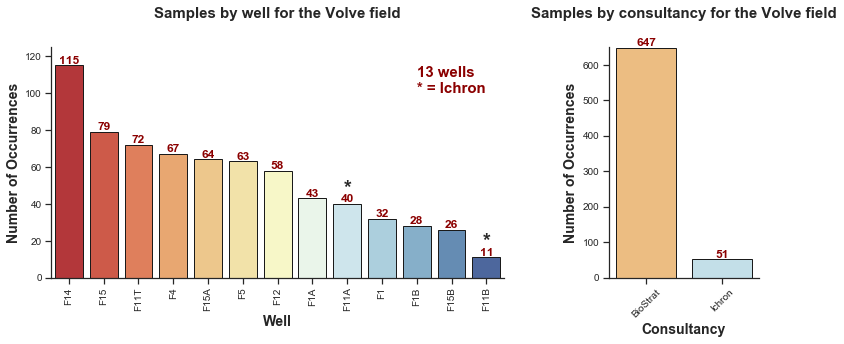

In [95]:
'''
How many samples are there per well?
'''
well_count  = info['SITE'].value_counts()

sns.set(style="ticks")

plt.subplots(figsize=(12,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
plt.subplot(gs[0])
ax = sns.barplot(well_count.index, well_count.values, alpha=1,palette="RdYlBu", linewidth=1, edgecolor='k')
ax.set_title('Samples by well for the Volve field', fontsize=15, weight='bold', y=1.1)
ax.set_ylabel('Number of Occurrences', fontsize=14, weight='bold')
ax.set_xlabel('Well', fontsize=14, weight='bold')
ax.tick_params(labelsize=10)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

#To print values above bars
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='darkred', weight='bold',xytext=(0, 5),
                 textcoords='offset points')
_ = ax.set_ylim(0,125) #To make space for the annotations

plt.text(10,100, "13 wells \n* = Ichron", fontsize = 15, color='darkred',weight='bold')
plt.text(8,45, '*',horizontalalignment='center', fontsize=20, weight='bold')
plt.text(12,16, '*',horizontalalignment='center', fontsize=20, weight='bold')

sns.despine()

'''
How many samples per consultancy are there? Two companies generated data: Ichron Ltd. and BioStrat Ltd.
'''
consult_count  = info['ANALYST'].value_counts()

plt.subplot(gs[1])
ax1 = sns.barplot(consult_count.index, consult_count.values, alpha=1,palette="RdYlBu", linewidth=1, edgecolor='k')
ax1.set_title('Samples by consultancy for the Volve field', fontsize=15, weight='bold', y=1.1)
ax1.set_ylabel('Number of Occurrences', fontsize=14, weight='bold')
ax1.set_xlabel('Consultancy', fontsize=14, weight='bold')
ax1.tick_params(labelsize=10)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

#To print values above bars
for p in ax1.patches:
             ax1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='darkred', weight='bold',xytext=(0, 5),
                 textcoords='offset points')
_ = ax1.set_ylim(0,650) #To make space for the annotations

plt.subplots_adjust(wspace=0.5, hspace=0.45)
plt.tight_layout()
sns.despine()

plt.show()
# plt.savefig('samples_consultancies_volve.png',dpi=400,bbox_inches='tight')

In [56]:
'''
Which wells were analysed by Ichon Ltd? Update the figure above with this information.
'''
ichron = info[(info['ANALYST'] == 'Ichron')] 
list(ichron['SITE'].unique())

['F11A', 'F11B']

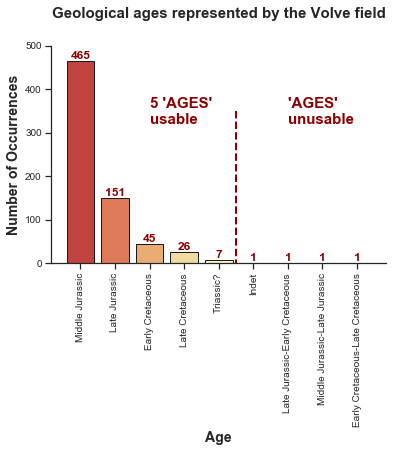

In [93]:
'''
How many different ages are there and what is the class imbalance?
'''

# Plotting a bar graph of the number of samples within each age bin.

age_count  = info['AGE'].value_counts()

sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.barplot(age_count.index, age_count.values, alpha=1,palette="RdYlBu", linewidth=1, edgecolor='k')
ax.set_title('Geological ages represented by the Volve field', fontsize=15, weight='bold',y=1.1)
ax.set_ylabel('Number of Occurrences', fontsize=14, weight='bold')
ax.set_xlabel('Age', fontsize=14, weight='bold')
ax.tick_params(labelsize=10)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

#To print values above bars
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='darkred', weight='bold',xytext=(0, 5),
                 textcoords='offset points')
_ = ax.set_ylim(0,500) #To make space for the annotations
plt.text(2,320, "5 'AGES' \nusable", fontsize = 15, color='darkred',weight='bold')
plt.text(6,320, "'AGES' \nunusable", fontsize = 15, color='darkred',weight='bold')
plt.plot([4.5,4.5], [350,0], linewidth=2, linestyle='--', color='darkred')

sns.despine()
plt.show()
# plt.savefig('Age_barchart_volve.png',dpi=400,bbox_inches='tight')

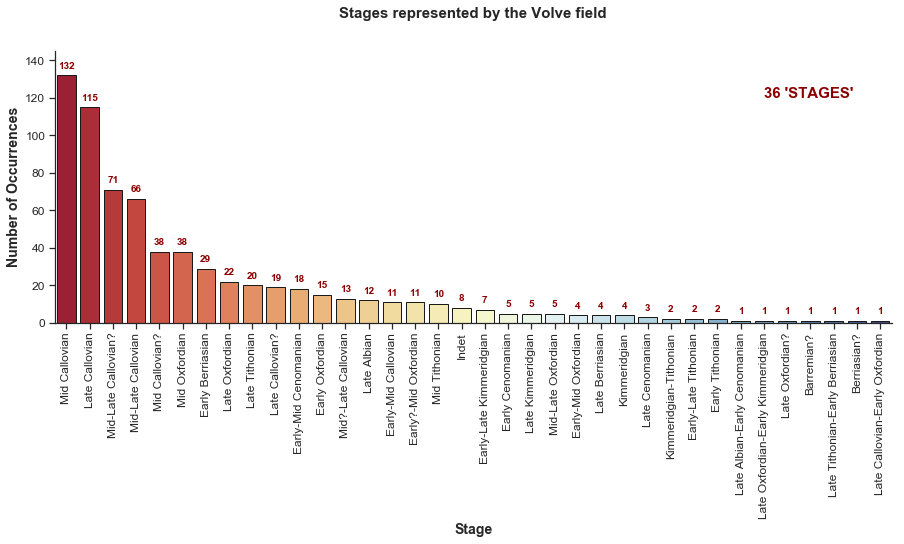

In [115]:
'''
How many different STAGEs are there and what is the class imbalance?
'''

# Plotting a bar graph of the number of samples within each stage bin.

stage_count  = info['STAGE'].value_counts()

sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(stage_count.index, stage_count.values, alpha=1,palette="RdYlBu", linewidth=1, edgecolor='k')
ax.set_title('Stages represented by the Volve field', fontsize=15, weight='bold', y=1.1)
ax.set_ylabel('Number of Occurrences', fontsize=14, weight='bold')
ax.set_xlabel('Stage', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.text(30,120, "36 'STAGES'", fontsize = 15, color='darkred',weight='bold')

#To print values above bars
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='darkred',weight='bold', xytext=(0, 5),
                 textcoords='offset points')
_ = ax.set_ylim(0,145) #To make space for the annotations

sns.despine()
plt.show()
# plt.savefig('Stages_barchart_volve.png',dpi=400,bbox_inches='tight')

In [96]:
##How many zones are present? Update figure above.
len(info.STAGE.value_counts())

36

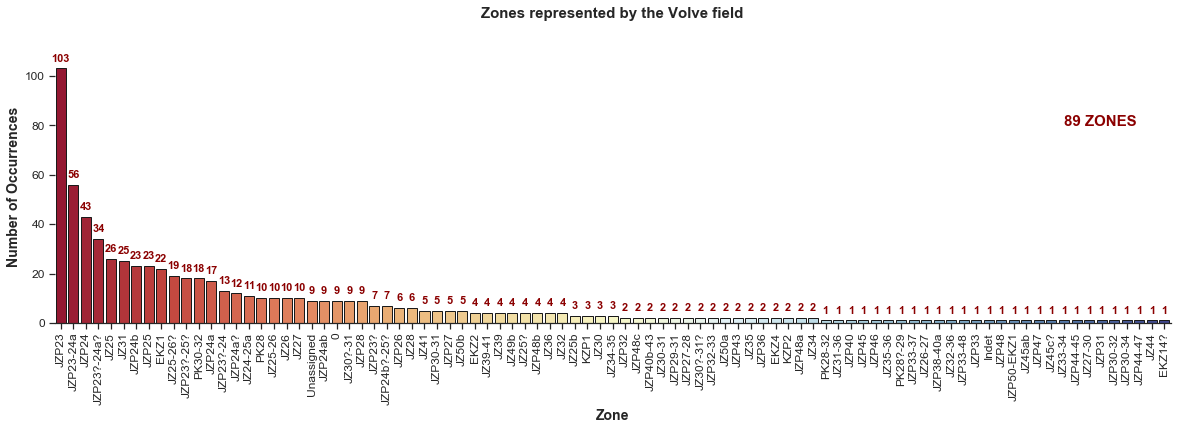

In [101]:
'''
How many different ZONEs are there and what is the class imbalance?
'''

# Plotting a bar graph of the number of samples within each zone bin.

zone_count  = info['ZONE'].value_counts()

sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.barplot(zone_count.index, zone_count.values, alpha=1,palette="RdYlBu", linewidth=1,edgecolor='k')
ax.set_title('Zones represented by the Volve field', fontsize=15, weight='bold', y=1.1)
ax.set_ylabel('Number of Occurrences', fontsize=14, weight='bold')
ax.set_xlabel('Zone', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.text(80,80, "89 ZONES", fontsize = 15, color='darkred',weight='bold')
#To print values above bars
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=11, color='darkred',weight='bold',xytext=(0, 5),
                 textcoords='offset points')
_ = ax.set_ylim(0,110) #To make space for the annotations
sns.despine(left='false', top='true', right='true')
plt.show()
# plt.savefig('Zones_barchart_volve.png',dpi=400,bbox_inches='tight')

In [50]:
##How many zones are present? Update above figure
len(info.ZONE.value_counts())

89

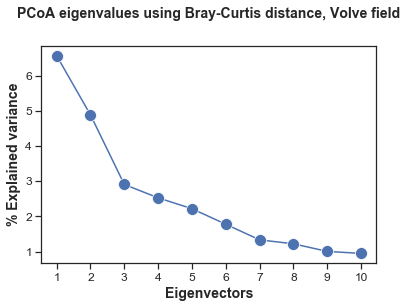

In [117]:
'''
Load the eigenvalues from the PCoA and show the explained variance.
'''
eigen = pd.read_csv('PCoA_eigenvalues_bray.csv') #computed using R and exported as .csv file
#eigen.head()

sns.set_style("ticks") #Shows tick marks on x and y axes.
fig, ax = plt.subplots(figsize=(6,4))

ax = sns.lineplot(data=eigen['x'][1:11], linewidth=1.5, marker='o', ms=12) #plot first 10 eigenvalues
ax.set_title('PCoA eigenvalues using Bray-Curtis distance, Volve field', fontsize=14, weight='bold', y=1.1)
ax.set_ylabel('% Explained variance', fontsize=14, weight='bold')
ax.set_xlabel('Eigenvectors', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
# plt.savefig('PCoA_eigenvalues_explained.png',dpi=400,bbox_inches='tight')

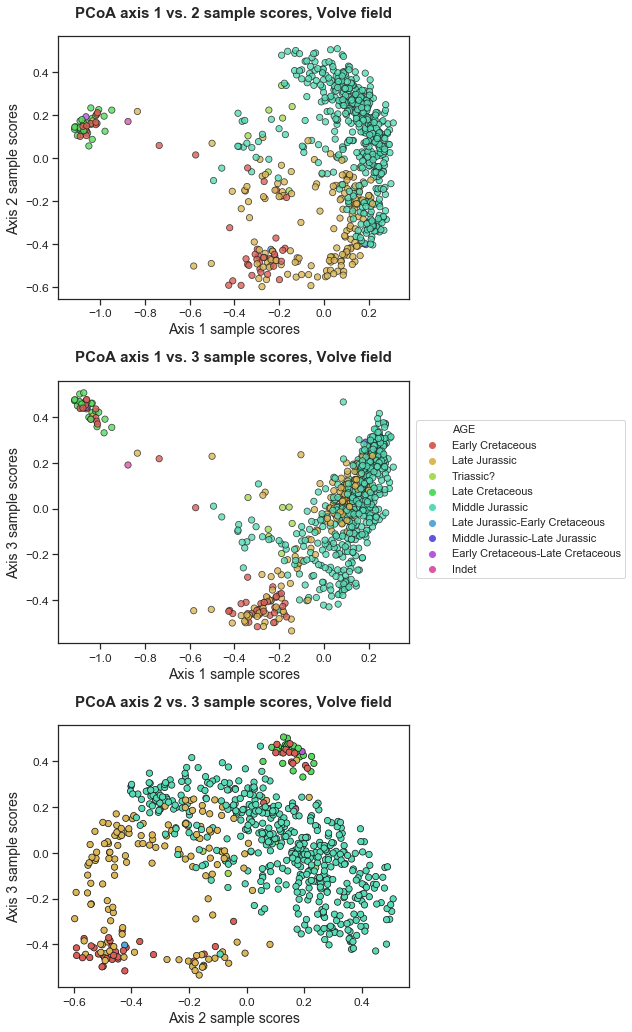

In [142]:
'''
Are the AGES really well defined? Plot PCoA results of axes 1,2 and 3 to explore how well separated
the AGES are from one another. How much variance do the first three axes explain?
'''
sns.set(style="ticks")

fig, ax = plt.subplots(figsize=(9,14))

plt.subplot(311)
ax1 = sns.scatterplot(x='AXIS_1', y='AXIS_2', hue='AGE', data=info,legend=False, 
                     alpha=0.8, s=40,palette="hls", edgecolor='k')
ax1.set_title('PCoA axis 1 vs. 2 sample scores, Volve field', fontsize=15, weight='bold', y=1.05)
ax1.set_ylabel('Axis 2 sample scores', fontsize=14)
ax1.set_xlabel('Axis 1 sample scores', fontsize=14)
ax1.tick_params(labelsize=12)

plt.tight_layout()

plt.subplot(312)
ax2 = sns.scatterplot(x='AXIS_1', y='AXIS_3', hue='AGE', data=info, 
                     alpha=0.8, s=40,palette="hls", edgecolor='k')
ax2.set_title('PCoA axis 1 vs. 3 sample scores, Volve field', fontsize=15, weight='bold', y=1.05)
ax2.set_ylabel('Axis 3 sample scores', fontsize=14)
ax2.set_xlabel('Axis 1 sample scores', fontsize=14)
ax2.tick_params(labelsize=12)

plt.legend(bbox_to_anchor=(1.02, 0.85),loc=2, borderaxespad=0.) #Plot legend outside area
plt.tight_layout()

plt.subplot(313)
ax3 = sns.scatterplot(x='AXIS_2', y='AXIS_3', hue='AGE', data=info,legend=False,
                     alpha=1, s=40,palette="hls", edgecolor='k')
ax3.set_title('PCoA axis 2 vs. 3 sample scores, Volve field', fontsize=15, weight='bold', y=1.05)
ax3.set_ylabel('Axis 3 sample scores', fontsize=14)
ax3.set_xlabel('Axis 2 sample scores', fontsize=14)
ax3.tick_params(labelsize=12)

plt.show()
#plt.savefig('PCoA_Volve_axes1_2_3.png',dpi=400,bbox_inches='tight')

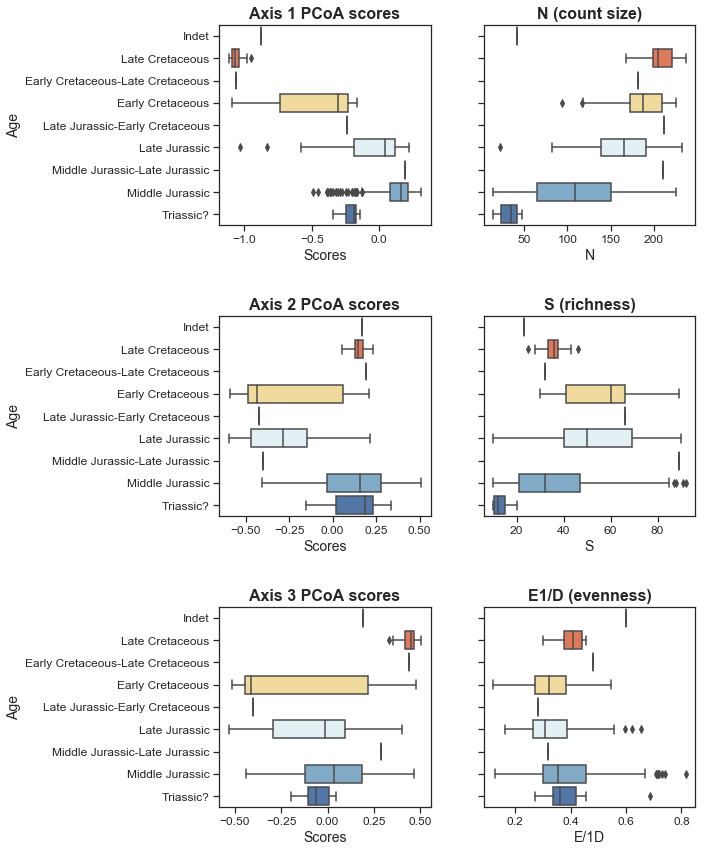

In [144]:
'''
How are the PCoA values and other features distributed with regards to age?
'''
##Boxplot of Axis 1 sample scores:
order = ['Indet',
         'Late Cretaceous',
         'Early Cretaceous-Late Cretaceous',
         'Early Cretaceous',
         'Late Jurassic-Early Cretaceous',
         'Late Jurassic',
         'Middle Jurassic-Late Jurassic',
         'Middle Jurassic',
         'Triassic?']

plt.subplots(figsize=(10,12))
sns.set(style="ticks")

plt.figure(1)
ax=plt.subplot(321)
ax = sns.boxplot(x="AXIS_1", y="AGE", data=info, ax=ax, palette="RdYlBu", 
                 order=order)
ax.axes.set_title("Axis 1 PCoA scores", weight='bold',fontsize=16)
ax.set_ylabel("Age",fontsize=14)
ax.set_xlabel("Scores",fontsize=14)
ax.tick_params(labelsize=12)

ax1=plt.subplot(323)
ax1 = sns.boxplot(x="AXIS_2", y="AGE", data=info, ax=ax1, palette="RdYlBu", 
                 order=order)
ax1.axes.set_title("Axis 2 PCoA scores", weight='bold',fontsize=16)
ax1.set_ylabel("Age",fontsize=14)
ax1.set_xlabel("Scores",fontsize=14)
ax1.tick_params(labelsize=12)

ax2=plt.subplot(325)
ax2 = sns.boxplot(x="AXIS_3", y="AGE", data=info, ax=ax2, palette="RdYlBu", 
                 order=order)
ax2.axes.set_title("Axis 3 PCoA scores", weight='bold',fontsize=16)
ax2.set_ylabel("Age",fontsize=14)
ax2.set_xlabel("Scores",fontsize=14)
ax2.tick_params(labelsize=12)

ax3=plt.subplot(322)
ax3 = sns.boxplot(x="N", y="AGE", data=info, ax=ax3, palette="RdYlBu", 
                 order=order)
ax3.axes.set_title("N (count size)", weight='bold',fontsize=16)
ax3.set_xlabel("N",fontsize=14)
ax3.set_ylabel('')
ax3.set_yticklabels('')
ax3.tick_params(labelsize=12)

ax4=plt.subplot(324)
ax4 = sns.boxplot(x="S", y="AGE", data=info, ax=ax4, palette="RdYlBu", 
                 order=order)
ax4.axes.set_title("S (richness)", weight='bold',fontsize=16)
ax4.set_ylabel('')
ax4.set_xlabel("S",fontsize=14)
ax4.set_yticklabels('')
ax4.tick_params(labelsize=12)

ax5=plt.subplot(326)
ax5 = sns.boxplot(x="E1.D", y="AGE", data=info, ax=ax5, palette="RdYlBu", 
                 order=order)
ax5.axes.set_title("E1/D (evenness)", weight='bold',fontsize=16)
ax5.set_ylabel('')
ax5.set_xlabel("E/1D",fontsize=14)
ax5.set_yticklabels('')
ax5.tick_params(labelsize=12)


plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.45)
plt.show()
# plt.savefig('Boxplots_by_AGE_volve.png',dpi=400,bbox_inches='tight')

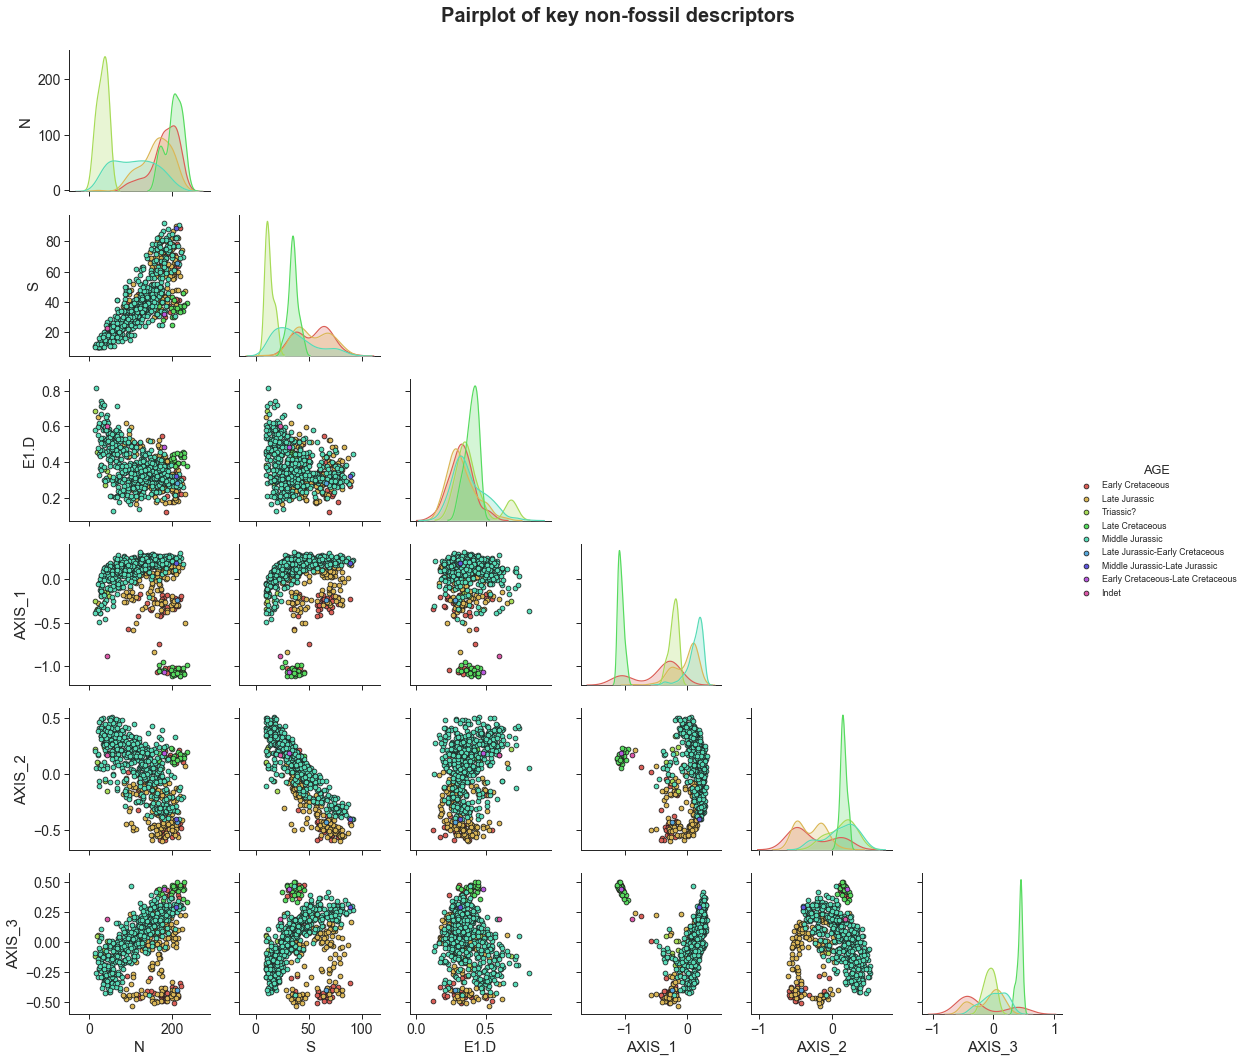

In [8]:
'''
What are the baseline metrics for some of the non-fossil features such as count size, richness, E/1D, and PCoA axes?
These might be important if there are mismatches between model predictions and actual classes.
'''

pp_features = info[['N','S','E1.D','AXIS_1','AXIS_2','AXIS_3','AGE']]

#Allow changes to label size by setting the context
sns.set(style="ticks")
sns.set_context("paper", rc={"axes.labelsize":15, 
                             "xtick.labelsize":14, 
                             "ytick.labelsize":14})

plt.figsize=(7.5,8)
g = sns.pairplot(pp_features, hue="AGE", palette='hls',plot_kws = {"edgecolor":'k'})#allow changes to line around scatter.
plt.suptitle('Pairplot of key non-fossil descriptors', weight='bold', fontsize=20)
plt.subplots_adjust(top=0.94)

for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False) #to plot with upper part masked.

plt.legend(bbox_to_anchor=(1.02, 0.85),loc=2, fontsize=50,borderaxespad=0.) #Plot legend outside area
plt.show()
# plt.savefig('Pairplot_volve.png',dpi=400,bbox_inches='tight')


The boxplots and the pairplot - despite its messiness - indicate that there are trends in the number of species ('S') recovered within different timebins and that the number of specimens that can be countedvaries by time-bin ('N', the countsize). These are best demonstrated by the boxplots but the pairplot also show the effect of 'S' and 'N' on the PCoA axes. This can be better unpacked with a heatmap. E1/D doesn't appear to relate to any of these other features. It should be related to both S and N in some way.

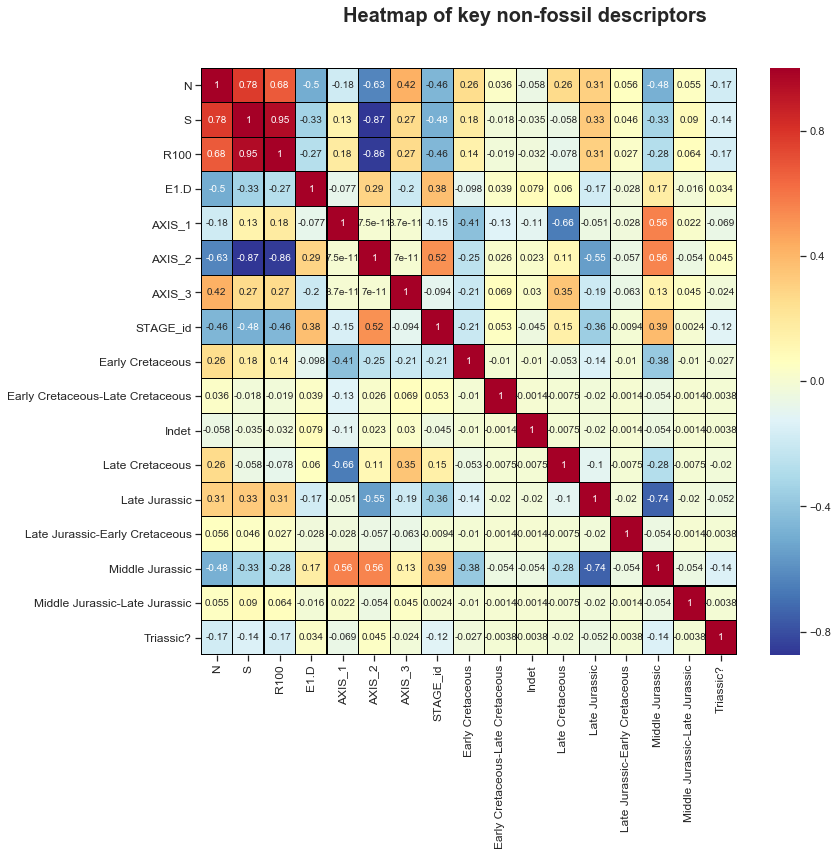

In [23]:
##Heatmap of key non-fossil features including PCoA

info_cut = info.drop(['AGE',
                      'AGE_id',
                      'STAGE',
                      'FORMATION',
                      'BASE',
                      'TYPE',
                      'ANALYST',
                      'SITE',
                      'LABEL',
                      'St.dev'], axis=1) #cut features that are hierarchially related to others (e.g. time) or just redundant.

info_cut_dum = pd.get_dummies(info['AGE']) 
info_cut_hm = pd.concat([info_cut, info_cut_dum], axis=1)

## construct cmap to match diagrams above:
#from matplotlib.colors import ListedColormap
#cmap = ListedColormap(sns.color_palette('YlOrBr_r', 256)) #actually redundant with YlOrBr or RdYlBu!

plt.subplots(figsize=(12,10))
ax=plt.subplot(111)
sns.heatmap(info_cut_hm.corr(), annot=True, cmap='RdYlBu_r', linewidth=0.25,linecolor='black') #-r reverse palette
plt.tick_params(labelsize=12)
plt.suptitle('Heatmap of key non-fossil descriptors', weight='bold', fontsize=20, y=1.025)
plt.subplots_adjust(top=0.94)

plt.show()
#plt.savefig('Heatmap_features_volve.png',dpi=400,bbox_inches='tight')

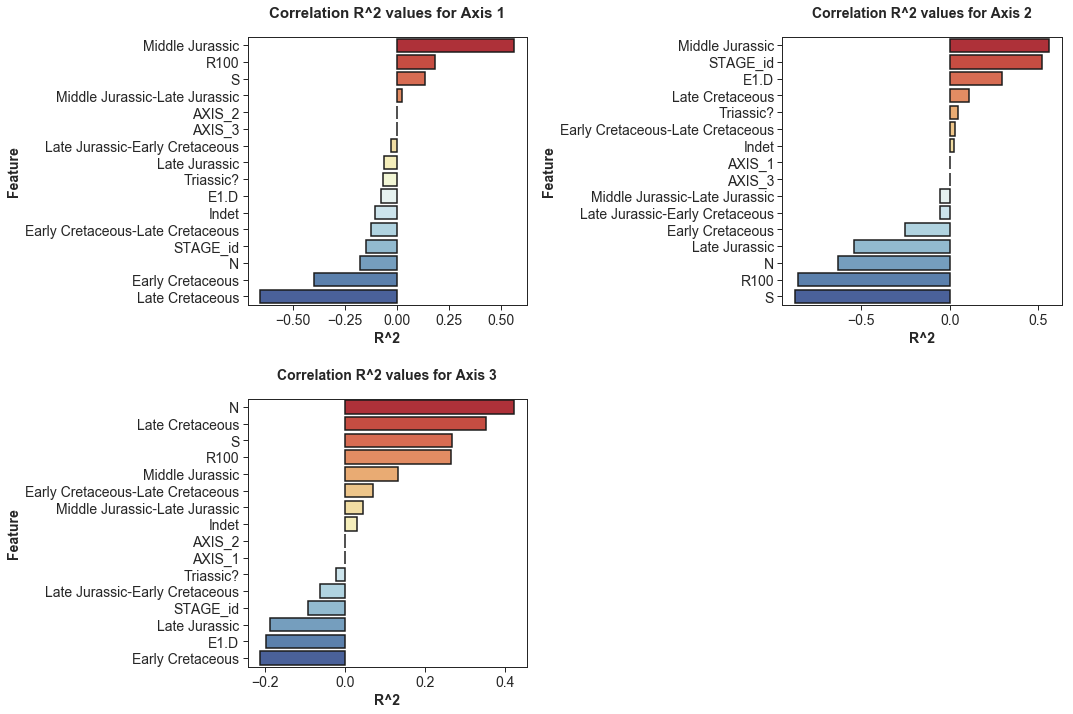

In [28]:
'''
It looks like the different eigenvectors are sensitive to different aspects of the data (also indicated by the pairplot).
Axis 1 could be AGE, and Axis 2 and 3 could be raw species richness and the count size. Show these relationships 
more effectively.
'''

##Get dummies for categories
core_1 = info_cut_hm.corr().AXIS_1
core_1.sort_values(ascending = False)

core_2 = info_cut_hm.corr().AXIS_2
core_2.sort_values(ascending = False)

core_3 = info_cut_hm.corr().AXIS_3
core_3.sort_values(ascending = False)

##Put values into dfs
x1 = pd.DataFrame(core_1.sort_values(ascending=False))
x2 = pd.DataFrame(core_2.sort_values(ascending=False))
x3 = pd.DataFrame(core_3.sort_values(ascending=False))

##Extract names of features
names_1 = list(x1.index)
names_2 = list(x2.index)
names_3 = list(x3.index)

##Extract values of features
values_1 = list(x1.AXIS_1)
values_2 = list(x2.AXIS_2)
values_3 = list(x3.AXIS_3)

f, ax = plt.subplots(figsize=(15, 10))


plt.subplot(221)
ax1 = sns.barplot(x=values_1[1:], y=names_1[1:], palette="RdYlBu", linewidth=1.5, edgecolor='k')
ax1.set_title('Correlation R^2 values for Axis 1', fontsize=15, weight='bold',y=1.05)
ax1.set_ylabel('Feature', fontsize=14, weight='bold')
ax1.set_xlabel('R^2', fontsize=14, weight='bold')

plt.subplot(222)
ax2 = sns.barplot(x=values_2[1:], y=names_2[1:], palette='RdYlBu', linewidth=1.5, edgecolor='k')
ax2.set_title('Correlation R^2 values for Axis 2', fontsize=14, weight='bold', y=1.05)
ax2.set_ylabel('Feature', fontsize=14, weight='bold')
ax2.set_xlabel('R^2', fontsize=14, weight='bold')

plt.subplot(223)
ax3 = sns.barplot(x=values_3[1:], y=names_3[1:], palette='RdYlBu', linewidth=1.5, edgecolor='k')
ax3.set_title('Correlation R^2 values for Axis 3', fontsize=14, weight='bold', y=1.05)
ax3.set_ylabel('Feature', fontsize=14, weight='bold')
ax3.set_xlabel('R^2', fontsize=14, weight='bold')

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)
plt.show()
#plt.savefig('barchart_correlation_axes_1_2_3.png',dpi=400,bbox_inches='tight')


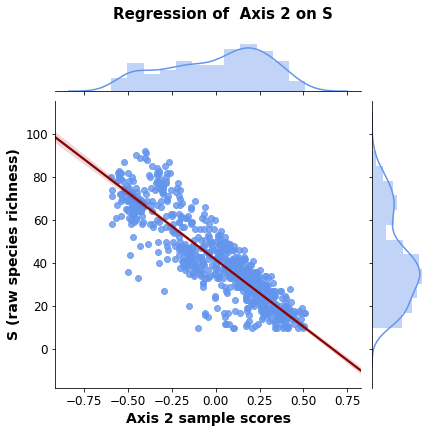

In [6]:
plt.figsize=(5,5)
sns.jointplot(x='AXIS_2',y='S',data=info, kind='reg',color='cornflowerblue',joint_kws={'line_kws':{'color':'darkred'}}) 
plt.ylabel('S (raw species richness)', fontsize=14, weight='bold')
plt.xlabel('Axis 2 sample scores', fontsize=14, weight='bold')
plt.tick_params(labelsize=12)
plt.suptitle('Regression of  Axis 2 on S', fontsize=15, weight='bold')
plt.subplots_adjust(top=0.9)

plt.show()
#plt.savefig('Regplot_axis2_S_volve.png',dpi=400,bbox_inches='tight')

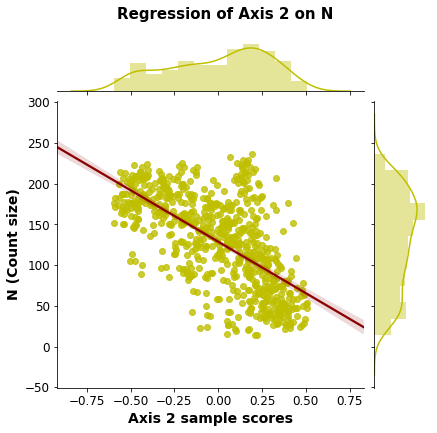

In [5]:
plt.figsize=(5,5)
sns.jointplot(x='AXIS_2',y='N',data=info, kind='reg',color='y',joint_kws={'line_kws':{'color':'darkred'}}) 
plt.ylabel('N (Count size)', fontsize=14, weight='bold')
plt.xlabel('Axis 2 sample scores', fontsize=14, weight='bold')
plt.tick_params(labelsize=12)
plt.suptitle('Regression of Axis 2 on N', fontsize=15, weight='bold')
plt.subplots_adjust(top=0.90)

plt.show()
# plt.savefig('Regplot_axis2_N_volve.png',dpi=400,bbox_inches='tight')

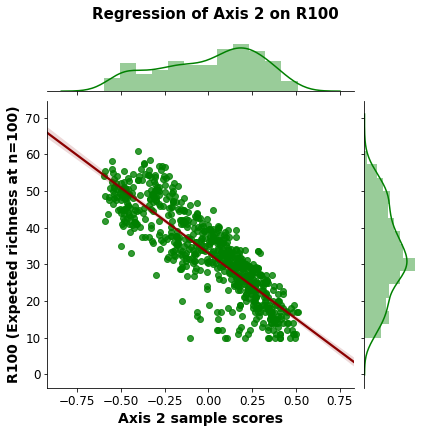

In [4]:
plt.figsize=(5,5)
sns.jointplot(x='AXIS_2',y='R100',data=info, kind='reg',color='g',joint_kws={'line_kws':{'color':'darkred'}}) 
plt.ylabel('R100 (Expected richness at n=100)', fontsize=14, weight='bold')
plt.xlabel('Axis 2 sample scores', fontsize=14, weight='bold')
plt.tick_params(labelsize=12)
plt.suptitle('Regression of Axis 2 on R100', fontsize=15, weight='bold')
plt.subplots_adjust(top=0.90)

plt.show()
# plt.savefig('Regplot_Axis2_R100_volve.png',dpi=400,bbox_inches='tight')

In [56]:
'''
Are the Axis_1 scores for the different age classes statistically significant from one another? 
Since the PCoA will result in a normal distributed output, check with a one-way ANOVA.
'''
early_k = info.loc[info['AGE'] == 'Early Cretaceous', 'AXIS_1']
late_k = info.loc[info['AGE'] == 'Late Cretaceous','AXIS_1']
late_j = info.loc[info['AGE'] == 'Late Jurassic','AXIS_1']
mid_j = info.loc[info['AGE'] == 'Middle Jurassic','AXIS_1']
trias = info.loc[info['AGE'] == 'Triassic?','AXIS_1']

F, p = stats.f_oneway(early_k, late_k, late_j, mid_j, trias)

# The F statistic.
print('F-test statistic: ',F )

# The probability.
print('p val: ',p)

F-test statistic:  422.12337995386815
p val:  1.2126888984965592e-183


# 3. Clustering 
### How many groups are really discernible in the data?

While labels are present for the data, these are determined by consultants and sometimes the age information can be highly subjective. Results from data compression using PCoA suggest there are two major trends: 1) A division between Late Cretaceous and everything else, 2) gradual change during the Jurassic. 

Other then being sparse, the additional attributes of the data are not obvious. Hence, it is worthwhile to run various clustering techniques that determine clusters using different algorithms. The relatively small size of the dataset means this will not take up too much time in the data exploration process. In this case, K-means and DBSCAN are run on the data to explore the presence of clusters of data. The rationale for each method is that K-Means is fast and the properties are well-understood. It has the drawback of using Euclidean distance, requires spherical data structures (that are almost certainly not represented: theses are probably linear), and _a priori_ a number of clusters selcted that are to be returned. DBSCAN works off density gradients and works with distinct centres of density within the data. It has the benefit of allowing outliers that are not coerced into clusters but might not perform on data with continuous gradients like the data suggest here (where are the density centres, for example?).

In [30]:
'''
K-MEANS
'''

Sum_of_squared_distances = [] #Use sum of squares distances.

K = range(1,11) #As K increase, ssq tends to zero
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    random_state=45
    Sum_of_squared_distances.append(km.inertia_)

#Code from Cambridge Spark and Raschka & Mirjalili (2018)

In [43]:
'''
Run model on 5 clusters to represent the five age bins with multiple observations within each 
(remaining 4 have only 1 sample each). Experiment with a silhouette plot to see what k=n works best.
'''
y_pred = KMeans(n_clusters=5, random_state=45).fit_predict(data)

##Insert y_pred as a column in info for plotting. Might be useful useful.
#info['y_pred_KMeans'] = y_pred

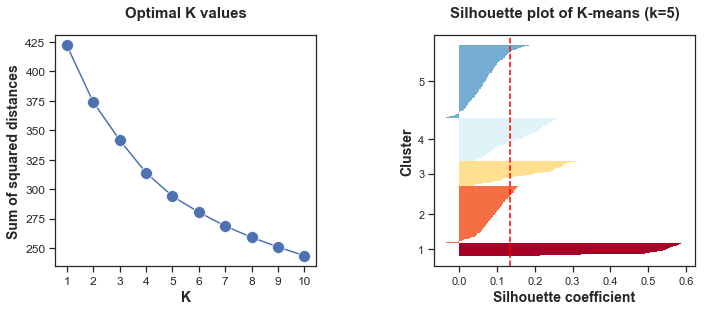

In [70]:
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(10,4.5))

'''
How many clusters are there?
'''
plt.subplot(121)
ax = sns.lineplot(x=K, y=Sum_of_squared_distances, linewidth=1.5, marker='o', ms=12) #plot first 10 eigenvalues
ax.set_title('Optimal K values', fontsize=15, weight='bold', y=1.05)
ax.set_ylabel('Sum of squared distances', fontsize=14, weight='bold')
ax.set_xlabel('K', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

'''
How sub-optimal is the clustering? Check with a silhouette plot.
Code adapted from Raschka & Mirjalili (2017), pp. 359-360.
'''
cluster_labels = np.unique(y_pred)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(data,
                                    y_pred,
                                    metric='euclidean')
plt.subplot(122)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_pred==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    palette = cm.RdYlBu(float(i)/n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none',
            color=palette)
    yticks.append((y_ax_lower + y_ax_upper)/2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
           color='red',
           linestyle='--')
plt.yticks(yticks, cluster_labels +1)
plt.ylabel('Cluster', fontsize=14, weight='bold')
plt.xlabel('Silhouette coefficient', fontsize=14, weight='bold')
plt.title('Silhouette plot of K-means (k=5)', fontsize=15, weight='bold', y=1.05)

plt.tight_layout()
plt.subplots_adjust(wspace=0.45)

plt.show()
# plt.savefig('K-elbow_silhouette.png',dpi=400,bbox_inches='tight')

There doesn't appear to be an elbow. Presumably this represents the complex structure of the data. The most balanced silhouette plot is k=5 and this is poor since there is disparity in cluster width, the mean is low, and there is an outlier cluster class. K-Means is not an appropriate method to employ on this data set. 

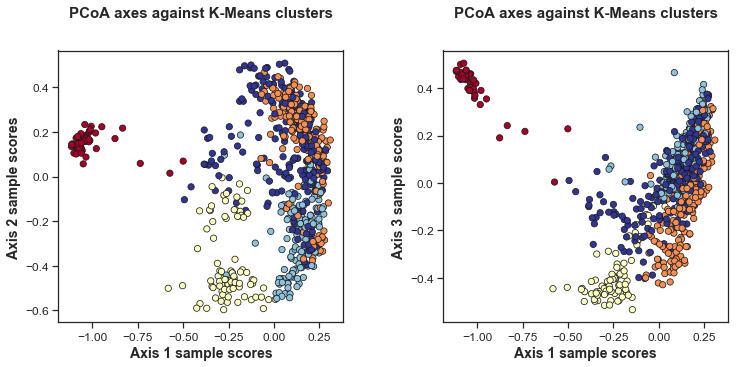

In [29]:
sns.set(style="ticks")

fig, ax = plt.subplots(figsize=(12,5))

plt.subplot(1,2,1)
ax = sns.scatterplot(x='AXIS_1', y='AXIS_2', data=info, hue='y_pred_KMeans', legend=False, 
                     alpha=1, s=40,palette='RdYlBu', edgecolor='k')
ax.set_title('PCoA axes against K-Means clusters', fontsize=15, weight='bold', y=1.1)
ax.set_ylabel('Axis 2 sample scores', fontsize=14, weight='bold')
ax.set_xlabel('Axis 1 sample scores', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)

plt.subplot(1,2,2)
ax = sns.scatterplot(x='AXIS_1', y='AXIS_3', data=info, hue='y_pred_KMeans', legend=False, 
                     alpha=1, s=40,palette='RdYlBu', edgecolor='k')
ax.set_title('PCoA axes against K-Means clusters', fontsize=15, weight='bold', y=1.1)
ax.set_ylabel('Axis 3 sample scores', fontsize=14, weight='bold')
ax.set_xlabel('Axis 1 sample scores', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)

plt.subplots_adjust(wspace=0.35)
plt.show()
# plt.savefig('KMeans_clusters.png',dpi=400,bbox_inches='tight')

K-Means does not perform well on the data - Plotting the clusters against PCoA axes 1 and 2 illustrates that information from other dimensions of the data is influencing the cluster pattern and is on a different plane than axes 1 and 2. The heatmap should show that ages mostly occur within one cluster. They do not. The elbow plot demonstrates no discernable elbow. 

In [81]:
'''
DBSCAN 
'''
db = DBSCAN(eps=0.67,
           min_samples=5) 
#eps is VERY sensitive. Not intuitive what the change does since it's hard to visualise. 0.67 generates 5 clusters.

y_db = db.fit_predict(data)
info['y_pred_DB'] = y_db #put onto df. -1 represents outliers (dark red)?

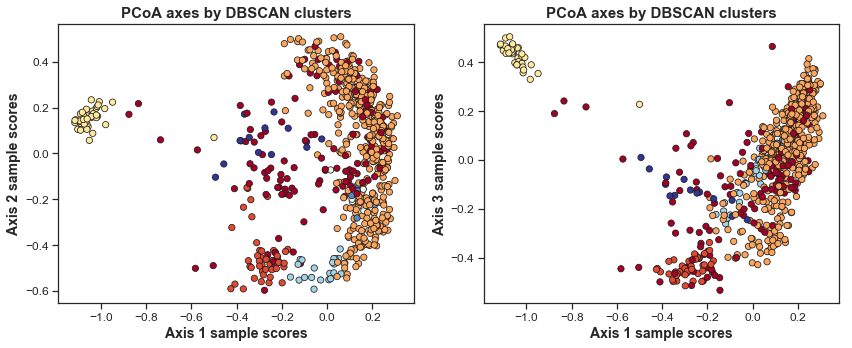

In [82]:
'''
What do the DBSCAN clusters look like PCoA?
'''
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(12,5))

plt.subplot(1,2,1)
ax = sns.scatterplot(x='AXIS_1', y='AXIS_2', data=info, hue='y_pred_DB', legend=False, 
                     alpha=1, s=40,palette='RdYlBu', edgecolor='k')
ax.set_title('PCoA axes by DBSCAN clusters', fontsize=15, weight='bold')
ax.set_ylabel('Axis 2 sample scores', fontsize=14, weight='bold')
ax.set_xlabel('Axis 1 sample scores', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)

plt.subplot(1,2,2)
ax = sns.scatterplot(x='AXIS_1', y='AXIS_3', data=info, hue='y_pred_DB', legend=False,
                     alpha=1, s=40,palette='RdYlBu', edgecolor='k')
ax.set_title('PCoA axes by DBSCAN clusters', fontsize=15, weight='bold')
ax.set_ylabel('Axis 3 sample scores', fontsize=14, weight='bold')
ax.set_xlabel('Axis 1 sample scores', fontsize=14, weight='bold')
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

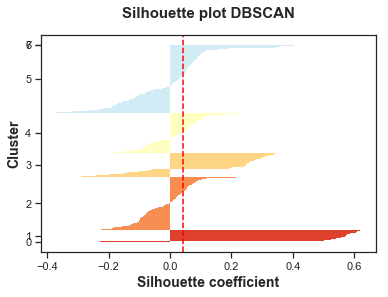

In [83]:
'''
How sub-optimal is the clustering? Check with a silhouette plot.
Code adapted from Raschka & Mirjalili (2017), pp. 359-360.
'''
cluster_labels = np.unique(y_db)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(data,
                                    y_db,
                                    metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_pred==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    palette = cm.RdYlBu(float(i)/n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none',
            color=palette)
    yticks.append((y_ax_lower + y_ax_upper)/2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
           color='red',
           linestyle='--')
plt.yticks(yticks, cluster_labels +1)
plt.ylabel('Cluster', fontsize=14, weight='bold')
plt.xlabel('Silhouette coefficient', fontsize=14, weight='bold')
plt.title('Silhouette plot DBSCAN', fontsize=15, weight='bold', y=1.05)


plt.show()

Different clustering algorithms all seem to perform badly as represented in these diagrams. The only method that seems to demonstrate intuitive clusters is K-Means even though the elbow plot and silhouette plots caution that the number of clusters is not an obvious fit. Clustering and ordination both demonstrate that __the data are high-dimensional, have classes of potential low-density, possibly elongated shape and are basically complex__ and almost certainly a result of the sparsity of the dataset. This has repercussions for the algorithms that can be used for supervised learning. 

Fuzzy-C and hierarchial clustering have been used previously on these types of data.

In [36]:
'''
Concatenate the info and data df and remove the singleton classes since these cannot be trained and tested. 
Save the master df and use this if starting a new session requiring ML.
'''
# #Concatenate info and data df together
# volve_full =pd.concat([info, data], axis=1)

# #Drop the rows with singletone classes in the AGE column
# volve_full = volve_full[~volve_full['AGE'].isin(['Indet',
#                              'Late Jurassic-Early Cretaceous',
#                              'Middle Jurassic-Late Jurassic',
#                              'Early Cretaceous-Late Cretaceous'])]

# #Check for any zero sum features
# volve_full_data = volve_full.iloc[:,22:]
# volve_full_data.sum().sort_values()
# list(volve_full_data.columns)

# volve_full_info = volve_full.iloc[:,:22]
# list(volve_full_info.columns)

# ##Save df for quick start
#volve_full.to_csv('volve_full.csv');

''

# 4. Supervised learning

In this section models are tuned for inclusion into an ensemble model, if necessary. Due to the class imbalance the AGE of the samples is predicted. There are lots of ZONES but many of these are represened by 1 or just a few samples. In addition there are different labels for the ZONES from the 2 consultancies that have provided data but these might represent the same age!

__If AGE can be modelled, then STAGE will be a good method to model using the best algorithm/algorithms determined on these data types by the modelling work on AGE.__

## 4.1. Modelling 'AGE'

In [75]:
##If starting a fresh session, load the df:

volve_full = pd.read_csv('volve_full.csv')
volve_full_data = volve_full.iloc[:,23:] #NB: check this hasn't added an unnamed column in [0]

<b>Note:</b> The data are really a form of time series although one with breaks of many millions of years and time-averaging within-samples of 1000s to maybe 100,000s of years. Each sample is a window onto the composition at any given place at any fiven time. If the time-resolution is coarse (such as these time bins) this doesn't matter much, but the finer the temporal resolution, the more caution will need to be placed on assembling training and test sets. Here, the data are split into a training and test set and assigned randomly. 

In [76]:
from sklearn.model_selection import train_test_split
X = volve_full_data
Y = volve_full['AGE']

X_train, x_test, Y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=45, stratify=Y)

In [77]:
print('Y_train labels:\n\n{}'.format(Y_train.value_counts().sort_index()))
print('\ny_test labels:\n\n{}'.format(y_test.value_counts().sort_index()))

Y_train labels:

Early Cretaceous     35
Late Cretaceous      20
Late Jurassic       112
Middle Jurassic     348
Triassic?             5
Name: AGE, dtype: int64

y_test labels:

Early Cretaceous     12
Late Cretaceous       6
Late Jurassic        37
Middle Jurassic     117
Triassic?             2
Name: AGE, dtype: int64


In [78]:
'''
Randomly oversample the data in case this improves the training of the models.
Since the smallest training class contains only 5 samples, this may generate more 
noise rather than robust training samples. The baseline performance of the training data
will be compared with the oversampled data.
'''

## Randomly over-sampling data.
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=45) #use defaults: But can manually change no. of samples per class
X_resampled, y_resampled = ros.fit_resample(X_train, Y_train)

## Using synthetic over-sampling by K-means distance. Worth a shot.
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='not majority',k_neighbors=3, random_state=45) #use defaults again.
X_sm, y_sm = smote.fit_sample(X_train, Y_train)

from collections import Counter
print('\nOriginal data: \n',sorted(Counter(Y_train).items()))
print('Randomly oversampled data: \n', sorted(Counter(y_resampled).items()))
print('SMOTE data: \n', sorted(Counter(y_sm).items()))



Original data: 
 [('Early Cretaceous', 35), ('Late Cretaceous', 20), ('Late Jurassic', 112), ('Middle Jurassic', 348), ('Triassic?', 5)]
Randomly oversampled data: 
 [('Early Cretaceous', 348), ('Late Cretaceous', 348), ('Late Jurassic', 348), ('Middle Jurassic', 348), ('Triassic?', 348)]
SMOTE data: 
 [('Early Cretaceous', 348), ('Late Cretaceous', 348), ('Late Jurassic', 348), ('Middle Jurassic', 348), ('Triassic?', 348)]


In [79]:
##Generate a list of labels for the heatmaps (these are sorted alphabetically, so sort them here)

labels = []
items = sorted(Counter(Y_train).items())

for label, value in items:
     labels.append(label)
    
print(labels)

['Early Cretaceous', 'Late Cretaceous', 'Late Jurassic', 'Middle Jurassic', 'Triassic?']


### Multinomial Naive Bayes

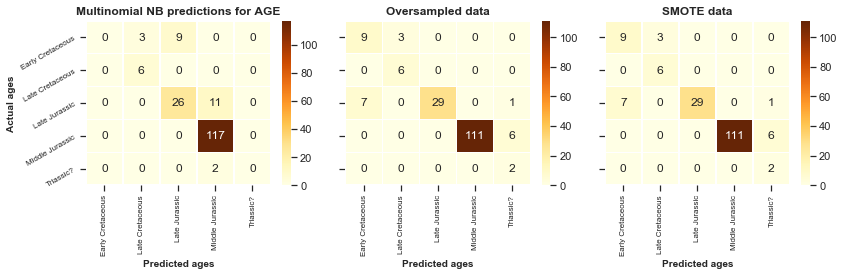

In [80]:
'''
NAIVE BAYES
'''

nb = MultinomialNB()

nb.fit(X_train, Y_train)
y_pred = nb.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,4))

plt.subplot(1,3,1)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr', 
                 xticklabels=labels, yticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=10, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax.set_title('Multinomial NB predictions for AGE', fontsize=12, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=30)
ax.tick_params(labelsize=8)

#Over-sampled data
plt.subplot(1,3,2)
nb1 = MultinomialNB()
nb1.fit(X_resampled, y_resampled)
y_pred1 = nb1.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred1)

ax1 = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                 xticklabels=labels)
ax1.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax1.set_title('Oversampled data', fontsize=12, weight='bold')
ax1.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax1.set_yticklabels('')
ax1.tick_params(labelsize=8)

#SMOTE data
plt.subplot(1,3,3)
nb2 = MultinomialNB()
nb2.fit(X_sm, y_sm)
y_pred2 = nb2.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred2)

ax2 = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                 xticklabels=labels)
ax2.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax2.set_title('SMOTE data', fontsize=12, weight='bold')
ax2.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax2.set_yticklabels('')
ax2.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
# plt.savefig('NB_prediction_heatmaps_AGE.png',dpi=400,bbox_inches='tight')

In [13]:
'''
How good are the models for the Multinomial Naive Bayes?
'''

print('Accuracy training set NB (no oversampling): {:.3f}'.format(nb.score(X_train, Y_train)))
print('Accuracy test set NB (no oversampling): {:.3f}'.format(nb.score(x_test, y_test)))
print('\nAccuracy training set NB (Oversampled): {:.3f}'.format(nb1.score(X_train, Y_train)))
print('Accuracy test set NB (Oversampled): {:.3f}'.format(nb1.score(x_test, y_test)))
print('\nAccuracy training set NB (SMOTE): {:.3f}'.format(nb2.score(X_train, Y_train)))
print('Accuracy test set NB (SMOTE): {:.3f}'.format(nb2.score(x_test, y_test)))

Accuracy training set NB (no oversampling): 0.867
Accuracy test set NB (no oversampling): 0.856

Accuracy training set NB (Oversampled): 0.925
Accuracy test set NB (Oversampled): 0.902

Accuracy training set NB (SMOTE): 0.927
Accuracy test set NB (SMOTE): 0.902


Accuracy of the model is fine if you have <b>balanced samples</b>. Clearly they are very unbalanced for the non-oversampled dataset. So while accuracy is fairly good, this is a reflection of the majority class. The confusion matrix clearly shows the total misses for the minority classes. It has learnt nothing about small classes. Precision and recall are therefore more informative.

In [24]:
'''
Calculate precision and recall of model
'''
print('Classification report for NB of raw data:\n')
print(classification_report(y_test, y_pred, target_names=labels))
print('\n\nClassification report for NB of oversampled data:\n')
print(classification_report(y_test, y_pred1, target_names=labels))

Classification report for NB of raw data:

                  precision    recall  f1-score   support

Early Cretaceous       0.00      0.00      0.00        12
 Late Cretaceous       0.67      1.00      0.80         6
   Late Jurassic       0.74      0.70      0.72        37
 Middle Jurassic       0.90      1.00      0.95       117
       Triassic?       0.00      0.00      0.00         2

       micro avg       0.86      0.86      0.86       174
       macro avg       0.46      0.54      0.49       174
    weighted avg       0.79      0.86      0.82       174



Classification report for NB of oversampled data:

                  precision    recall  f1-score   support

Early Cretaceous       0.56      0.75      0.64        12
 Late Cretaceous       0.67      1.00      0.80         6
   Late Jurassic       1.00      0.78      0.88        37
 Middle Jurassic       1.00      0.95      0.97       117
       Triassic?       0.22      1.00      0.36         2

       micro avg       0.90  

Naive Bayes is __surprisingly effective__ and very fast to implement. The increased number of samples through oversampling and SMOTE increase the power of the algorithm to detect small and medium sized classes.But it performs best for the majority classes *without oversampling* in any way. This is a potentially useful model.

Use oversampled or SMOTE data.

In [9]:
'''
Get the predictions from NB for the whole dataset (non oversampled) and attached these to a df so the missed classes
can be explored against other features.
'''
##Make an information df
# info = volve_full.iloc[:,:23]

##Run NB on data
# y_pred_nb = nb.predict(X)
# info['NB_predictions'] = y_pred_nb

### Random Forest 

In [293]:
'''
Tune the Random forest classifier
'''
##Tune parameters for Random Forest Classifier
param_grid = {'n_estimators':[100, 200, 300, 400], #Last iteration of grid.
             'max_depth': [40, 50, 60, 70]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=4)
grid.fit(X_train,Y_train)

print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross-validation score: 0.96
Best parameters:  {'n_estimators': 300, 'max_depth': 60}


In [294]:
##SMOTE data:

grid.fit(X_sm, y_sm)
print('Best cross-validation score (SMOTE) RFC: {:.2f}'.format(grid.best_score_))
print('Best parameters (SMOTE) RFC: ', grid.best_params_)

Best cross-validation score: 1.00
Best parameters:  {'n_estimators': 200, 'max_depth': 40}


In [295]:
##Randomly oversampled data:

grid.fit(X_resampled, y_resampled)
print('Best cross-validation score (Oversampled) RFC: {:.2f}'.format(grid.best_score_))
print('Best parameters (Oversampled) RFC: ', grid.best_params_)

Best cross-validation score: 1.00
Best parameters:  {'n_estimators': 200, 'max_depth': 40}


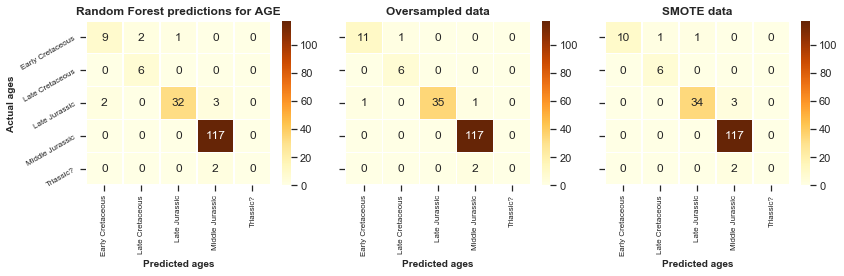

In [81]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=60, random_state=45)
rfc.fit(X_train, Y_train)
y_pred = rfc.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,4))

plt.subplot(1,3,1)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=10, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax.set_title('Random Forest predictions for AGE', fontsize=12, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=8)

#Over-sampled data
plt.subplot(1,3,2)
rfc1 = RandomForestClassifier(n_estimators=200, max_depth=40, random_state=45)
rfc1.fit(X_resampled, y_resampled)
y_pred1 = rfc1.predict(x_test)

conf_mat1 = confusion_matrix(y_test, y_pred1)

ax1 = sns.heatmap(conf_mat1, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr', xticklabels=labels)
#ax1.set_ylabel('Actual ages', fontsize=10, weight='bold')
ax1.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax1.set_title('Oversampled data', fontsize=12, weight='bold')
ax1.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax1.set_yticklabels('')
ax1.tick_params(labelsize=8)

#SMOTE data
plt.subplot(1,3,3)
rfc2 = RandomForestClassifier(n_estimators=200, max_depth=40, random_state=45)
rfc2.fit(X_sm, y_sm)
y_pred2 = rfc2.predict(x_test)
conf_mat2 = confusion_matrix(y_test, y_pred2)

ax2 = sns.heatmap(conf_mat2, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr', 
                  xticklabels=labels)
ax2.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax2.set_title('SMOTE data', fontsize=12, weight='bold')
ax2.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax2.set_yticklabels('')
ax2.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
# plt.savefig('RFC_prediction_heatmaps_AGE.png',dpi=400,bbox_inches='tight')

In [11]:
'''
How good are the models for the Random Forest Classifier?
'''
print('Accuracy training set RFC (no oversampling): {:.3f}'.format(rfc.score(X_train, Y_train)))
print('Accuracy test set RFC (no oversampling): {:.3f}'.format(rfc.score(x_test, y_test)))
print('\nAccuracy training set RFC (Oversampled): {:.3f}'.format(rfc1.score(X_train, Y_train)))
print('Accuracy test set RFC (Oversampled): {:.3f}'.format(rfc1.score(x_test, y_test)))
print('\nAccuracy training set RFC (SMOTE): {:.3f}'.format(rfc2.score(X_train, Y_train)))
print('Accuracy test set RFC (SMOTE): {:.3f}'.format(rfc2.score(x_test, y_test)))

Accuracy training set RFC (no oversampling): 1.000
Accuracy test set RFC (no oversampling): 0.943

Accuracy training set RFC (Oversampled): 1.000
Accuracy test set RFC (Oversampled): 0.971

Accuracy training set RFC (SMOTE): 1.000
Accuracy test set RFC (SMOTE): 0.960


In [26]:
'''
Calculate precision and recall of model
'''
print('Classification report for RFC of raw data:\n')
print(classification_report(y_test, y_pred, target_names=labels))
print('\n\nClassification report for RFC of oversampled data:\n')
print(classification_report(y_test, y_pred1, target_names=labels))

Classification report for RFC of raw data:

                  precision    recall  f1-score   support

Early Cretaceous       0.82      0.75      0.78        12
 Late Cretaceous       0.75      1.00      0.86         6
   Late Jurassic       0.97      0.86      0.91        37
 Middle Jurassic       0.96      1.00      0.98       117
       Triassic?       0.00      0.00      0.00         2

       micro avg       0.94      0.94      0.94       174
       macro avg       0.70      0.72      0.71       174
    weighted avg       0.93      0.94      0.94       174



Classification report for RFC of oversampled data:

                  precision    recall  f1-score   support

Early Cretaceous       0.92      0.92      0.92        12
 Late Cretaceous       0.86      1.00      0.92         6
   Late Jurassic       1.00      0.95      0.97        37
 Middle Jurassic       0.97      1.00      0.99       117
       Triassic?       0.00      0.00      0.00         2

       micro avg       0.97

The Random Forest Classifier performs very well and randomly oversampling and SMOTE both increase performance of the training power. However, inspection of the heatmaps shows they have slight difference in contrast to the multinomial NB. In this case **Randomly oversampled** data seem to have the slight edge on predictive power despite the same accuracy score overall: it can't detect 'Triassic?' although performs slightly worse on 'Late Jurassic' samples. 

The precision and recall improve through over-sampling. 

In [20]:
##Get all predictions and attached to info df
# y_pred_rfc = rfc.predict(X)

# info['RFC_predictions'] = y_pred_rfc

### Gradient Boosting Classifier

In [29]:
'''
Tune the Gradient boosting classifier
'''
##Tune parameters for GBC
param_grid = {'n_estimators':[50, 100, 150, 200],
             'learning_rate': [0.01, 0.1, 0.15, 0.2]}
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=4)
grid.fit(X_train,Y_train)

print('Best cross-validation score GBC: {:.2f}'.format(grid.best_score_))
print('Best parameters GBC: ', grid.best_params_)

Best cross-validation score: 0.96
Best parameters:  {'n_estimators': 100, 'learning_rate': 0.1}


In [31]:
##SMOTE data:

grid.fit(X_sm, y_sm)
print('Best cross-validation score (SMOTE) GBC: {:.2f}'.format(grid.best_score_))
print('Best parameters (SMOTE) GBC: ', grid.best_params_)

Best cross-validation score (SMOTE) GBC: 0.99
Best parameters (SMOTE) GBC:  {'n_estimators': 150, 'learning_rate': 0.2}


In [32]:
##Randomly oversampled data:

grid.fit(X_resampled, y_resampled)
print('Best cross-validation score (Oversampled) GBC: {:.2f}'.format(grid.best_score_))
print('Best parameters (Oversampled) GBC: ', grid.best_params_)

Best cross-validation score (Oversampled) GBC: 1.00
Best parameters (Oversampled) GBC:  {'n_estimators': 50, 'learning_rate': 0.1}


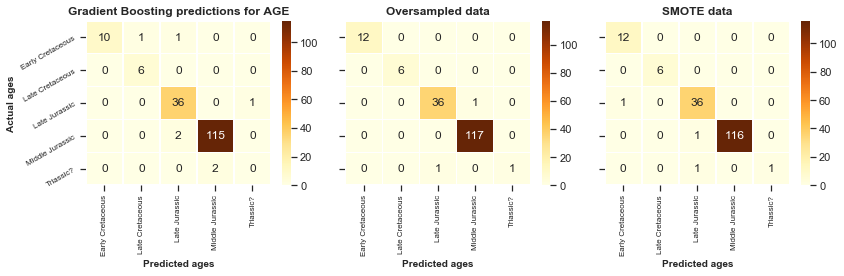

In [84]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=45)
gb.fit(X_train, Y_train)
y_pred = gb.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,4))

plt.subplot(1,3,1)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=10, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax.set_title('Gradient Boosting predictions for AGE', fontsize=12, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=8)

#Over-sampled data
plt.subplot(1,3,2)
gb1 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=45)
gb1.fit(X_resampled, y_resampled)
y_pred1 = gb1.predict(x_test)

conf_mat1 = confusion_matrix(y_test, y_pred1)

ax1 = sns.heatmap(conf_mat1, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                 xticklabels=labels)
ax1.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax1.set_title('Oversampled data', fontsize=12, weight='bold')
ax1.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax1.set_yticklabels('')
ax1.tick_params(labelsize=8)

#SMOTE data
plt.subplot(1,3,3)
gb2 = GradientBoostingClassifier(n_estimators=150, learning_rate=0.2, random_state=45)
gb2.fit(X_sm, y_sm)
y_pred2 = gb2.predict(x_test)
conf_mat2 = confusion_matrix(y_test, y_pred2)

ax2 = sns.heatmap(conf_mat2, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                 xticklabels=labels)
ax2.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax2.set_title('SMOTE data', fontsize=12, weight='bold')
ax2.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax2.set_yticklabels('')
ax2.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
# plt.savefig('GB_prediction_heatmaps_AGE.png',dpi=400,bbox_inches='tight')

In [86]:
'''
Calculate precision and recall of the GB model. Don't bother with 'Accuracy' - results of other tests
demnstrate it is not appropriate for this imbalance. The weighted-aerage recall is approximately the same.
'''
print('Classification report for GB of raw data:\n')
print(classification_report(y_test, y_pred, target_names=labels))
print('\n\nClassification report for GB of oversampled data:\n')
print(classification_report(y_test, y_pred1, target_names=labels))

Classification report for GB of raw data:

                  precision    recall  f1-score   support

Early Cretaceous       1.00      0.83      0.91        12
 Late Cretaceous       0.86      1.00      0.92         6
   Late Jurassic       0.92      0.97      0.95        37
 Middle Jurassic       0.98      0.98      0.98       117
       Triassic?       0.00      0.00      0.00         2

       micro avg       0.96      0.96      0.96       174
       macro avg       0.75      0.76      0.75       174
    weighted avg       0.96      0.96      0.96       174



Classification report for GB of oversampled data:

                  precision    recall  f1-score   support

Early Cretaceous       1.00      1.00      1.00        12
 Late Cretaceous       1.00      1.00      1.00         6
   Late Jurassic       0.97      0.97      0.97        37
 Middle Jurassic       0.99      1.00      1.00       117
       Triassic?       1.00      0.50      0.67         2

       micro avg       0.99  

The Gradient Boosting Classifer is slow to run but powerful. In this particular case the data generated by random-over-sampling seem to offer the best training set and manage to classify all values for 'Early Cretaceous'. The non-oversampled data manage to classify all  'Late Cretaceous' correctly which may indicate that the classifier is sufficiently powerful to recognise real values from auto-generated ones. This may have implications for how a MLP might respond to the data. This algorithm has learnt new things compared to the RFC but this is at the cost of speed.

In [23]:
##Get predictions on whole dataset
# y_pred_gb = gb.predict(X)
# info['GB_predictions'] = y_pred_gb

### Logistic regression

In [8]:
'''
Tune the Logistic regression.
'''

param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}
#do in a log series (a convention).NB: Changing penalties doesn't alter CV score.

grid = GridSearchCV(LogisticRegression(solver='lbfgs', multi_class='multinomial'), param_grid, cv=5, n_jobs=4)
grid.fit(X_train,Y_train)

print('Best cross-validation score (no oversampling) LR: {:.2f}'.format(grid.best_score_))
print('Best parameters (no oversampling) LR: ', grid.best_params_)

Best cross-validation score (no oversampling) LR: 0.98
Best parameters (no oversampling) LR:  {'C': 100}


In [9]:
##SMOTE data:

grid.fit(X_sm, y_sm)
print('Best cross-validation score (SMOTE) LR: {:.2f}'.format(grid.best_score_))
print('Best parameters (SMOTE) LR: ', grid.best_params_)

Best cross-validation score (SMOTE) LR: 1.00
Best parameters (SMOTE) LR:  {'C': 100}


In [10]:
##Randomly oversampled data:

grid.fit(X_resampled, y_resampled)
print('Best cross-validation score (Oversampled) LR: {:.2f}'.format(grid.best_score_))
print('Best parameters (Oversampled) LR: ', grid.best_params_)

Best cross-validation score (Oversampled) LR: 1.00
Best parameters (Oversampled) LR:  {'C': 100}


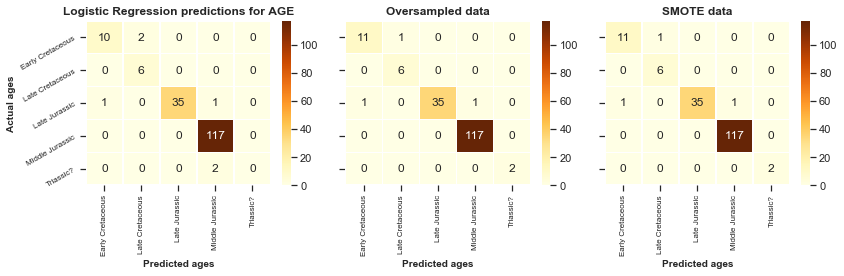

In [88]:
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial',C=10, random_state=45)
lr.fit(X_train, Y_train)
y_pred = lr.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,4))

plt.subplot(1,3,1)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=10, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax.set_title('Logistic Regression predictions for AGE', fontsize=12, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=8)

#Over-sampled data
plt.subplot(1,3,2)
lr1 = LogisticRegression(solver='lbfgs', multi_class='multinomial',C=100, random_state=45)
lr1.fit(X_resampled, y_resampled)
y_pred1 = lr1.predict(x_test)

conf_mat1 = confusion_matrix(y_test, y_pred1)

ax1 = sns.heatmap(conf_mat1, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                 xticklabels=labels)
ax1.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax1.set_title('Oversampled data', fontsize=12, weight='bold')
ax1.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax1.set_yticklabels('')
ax1.tick_params(labelsize=8)

#SMOTE data
plt.subplot(1,3,3)
lr2 = LogisticRegression(solver='lbfgs', multi_class='multinomial',C=100, random_state=45)
lr2.fit(X_sm, y_sm)
y_pred2 = lr2.predict(x_test)
conf_mat2 = confusion_matrix(y_test, y_pred2)

ax2 = sns.heatmap(conf_mat2, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                 xticklabels=labels)
ax2.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax2.set_title('SMOTE data', fontsize=12, weight='bold')
ax2.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax2.set_yticklabels('')
ax2.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
# plt.savefig('LR_prediction_heatmaps_AGE.png',dpi=400,bbox_inches='tight')

In [89]:
'''
Calculate precision and recall of LR models
'''
print('Classification report for LR of raw data:\n')
print(classification_report(y_test, y_pred, target_names=labels))
print('\n\nClassification report for LR of oversampled data:\n')
print(classification_report(y_test, y_pred1, target_names=labels))

Classification report for LR of raw data:

                  precision    recall  f1-score   support

Early Cretaceous       0.91      0.83      0.87        12
 Late Cretaceous       0.75      1.00      0.86         6
   Late Jurassic       1.00      0.95      0.97        37
 Middle Jurassic       0.97      1.00      0.99       117
       Triassic?       0.00      0.00      0.00         2

       micro avg       0.97      0.97      0.97       174
       macro avg       0.73      0.76      0.74       174
    weighted avg       0.96      0.97      0.96       174



Classification report for LR of oversampled data:

                  precision    recall  f1-score   support

Early Cretaceous       0.92      0.92      0.92        12
 Late Cretaceous       0.86      1.00      0.92         6
   Late Jurassic       1.00      0.95      0.97        37
 Middle Jurassic       0.99      1.00      1.00       117
       Triassic?       1.00      1.00      1.00         2

       micro avg       0.98  

Logistic Regression performs very well and in the case of the oversampled data performs as well as the tree based methods. Even the non-oversampled data perform excellently although the minority classes are not as well detected as with the oversampled data set. This method is fast and effective and works in a different way from either NB or the tree methods.

In [26]:
##Get all predictions against X
# y_pred_lr = lr.predict(X)
# info['LR_predictions'] = y_pred_lr

### Support Vector Machine

In [13]:
'''
Tune the SVM
'''

param_grid = {'C':[0.001, 0.01, 0.1, 1, 10],
             'gamma': [0.001,0.01, 0.1, 1, 10],
             'kernel': ['rbf', 'linear', 'poly']}
#do in a log series (a convention).NB: Changing penalties doesn't alter CV score.

grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=4)
grid.fit(X_train,Y_train)

print('Best cross-validation score (no oversampling) SVC: {:.2f}'.format(grid.best_score_))
print('Best parameters (no oversampling) SVC: ', grid.best_params_)

Best cross-validation score (no oversampling) SVC: 0.98
Best parameters (no oversampling) SVC:  {'gamma': 1, 'kernel': 'rbf', 'C': 10}


In [14]:
##SMOTE data:

grid.fit(X_sm, y_sm)
print('Best cross-validation score (SMOTE) SVC: {:.2f}'.format(grid.best_score_))
print('Best parameters (SMOTE) SVC: ', grid.best_params_)

Best cross-validation score (SMOTE) SVC: 1.00
Best parameters (SMOTE) SVC:  {'gamma': 10, 'kernel': 'poly', 'C': 0.001}


In [15]:
##Randomly oversampled data:

grid.fit(X_resampled, y_resampled)
print('Best cross-validation score (Oversampled) SVC: {:.2f}'.format(grid.best_score_))
print('Best parameters (Oversampled) SVC: ', grid.best_params_)

Best cross-validation score (Oversampled) SVC: 1.00
Best parameters (Oversampled) SVC:  {'gamma': 10, 'kernel': 'poly', 'C': 0.01}


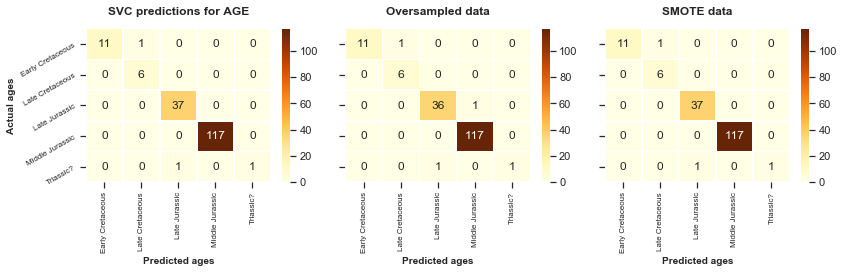

In [91]:
svc = SVC(C=10, gamma=1,kernel='rbf', probability=True, random_state=45) #set probability to True to get predict_probab()
svc.fit(X_train, Y_train)
y_pred = svc.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,4))

plt.subplot(1,3,1)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=10, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax.set_title('SVC predictions for AGE', fontsize=12, weight='bold', y=1.05)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=8)

#Over-sampled data
plt.subplot(1,3,2)
svc1 = SVC(C=0.01, gamma=10,kernel='poly', probability=True, random_state=45)
svc1.fit(X_resampled, y_resampled)
y_pred1 = svc1.predict(x_test)

conf_mat1 = confusion_matrix(y_test, y_pred1)

ax1 = sns.heatmap(conf_mat1, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                 xticklabels=labels)
ax1.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax1.set_title('Oversampled data', fontsize=12, weight='bold', y=1.05)
ax1.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax1.set_yticklabels('')
ax1.tick_params(labelsize=8)

#SMOTE data
plt.subplot(1,3,3)
svc2 = SVC(C=0.001, gamma=10,kernel='poly', probability=True, random_state=45)
svc2.fit(X_sm, y_sm)
y_pred2 = svc2.predict(x_test)
conf_mat2 = confusion_matrix(y_test, y_pred2)

ax2 = sns.heatmap(conf_mat2, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr', 
                  xticklabels=labels)
ax2.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax2.set_title('SMOTE data', fontsize=12, weight='bold', y=1.05)
ax2.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax2.set_yticklabels('')
ax2.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
# plt.savefig('SVC_prediction_heatmaps_AGE.png',dpi=400,bbox_inches='tight')

In [93]:
'''
Calculate precision and recall of SVC models
'''
print('Classification report for SVC of raw data:\n') #SMOTE will be identical
print(classification_report(y_test, y_pred, target_names=labels))
print('\n\nClassification report for SVC of oversampled data:\n')
print(classification_report(y_test, y_pred1, target_names=labels))

Classification report for SVC of raw data:

                  precision    recall  f1-score   support

Early Cretaceous       1.00      0.92      0.96        12
 Late Cretaceous       0.86      1.00      0.92         6
   Late Jurassic       0.97      1.00      0.99        37
 Middle Jurassic       1.00      1.00      1.00       117
       Triassic?       1.00      0.50      0.67         2

       micro avg       0.99      0.99      0.99       174
       macro avg       0.97      0.88      0.91       174
    weighted avg       0.99      0.99      0.99       174



Classification report for SVC of oversampled data:

                  precision    recall  f1-score   support

Early Cretaceous       1.00      0.92      0.96        12
 Late Cretaceous       0.86      1.00      0.92         6
   Late Jurassic       0.97      0.97      0.97        37
 Middle Jurassic       0.99      1.00      1.00       117
       Triassic?       1.00      0.50      0.67         2

       micro avg       0.98

The best kernel for the SVM is rbf for the non-oversampled data and 'poly' for the oversampled and SMOTE data and it has excellent performance on this high-dimensional dataset. In this case the __oversampling has no impact on the efficiency of the training process__. The performance of this algorithm (and the difficulty in reducing the dimensions through multivariate ordination) suggests that the data have a complex shape that has aspect of linearity but also other dimensions. Perhaps the increase of samples in the training set has no impact because each separate class occupies a different space (or dimension) in the dataset that the SVM can detect without the increase in sample sizes for training.

In [38]:
##Get all predictions against X
# y_pred_svc = svc.predict(X)
# info['SVC_predictions'] = y_pred_svc

### K-Nearest Neighbors

In [94]:
'''
Tune the KNN

The most significant tuning parameter is the number of neighbours to consider (k)
'''
training_accuracy = []
test_accuracy = []
training_accuracy_OS = []
test_accuracy_OS = []
training_accuracy_SM = []
test_accuracy_SM = []

neighbors = range(1,12,2) #use an odd number of neighbours as recommended by Albon (2018)

for n_neighbors in neighbors:
    #non oversampled data
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, Y_train)
    training_accuracy.append(knn.score(X_train, Y_train))
    test_accuracy.append(knn.score(x_test, y_test))
    
    #Randomly oversampled data
    knn1 = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn1.fit(X_resampled, y_resampled)
    training_accuracy_OS.append(knn1.score(X_resampled, y_resampled))
    test_accuracy_OS.append(knn1.score(x_test, y_test))

    #SMOTE data
    knn2 = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn2.fit(X_sm, y_sm)
    training_accuracy_SM.append(knn2.score(X_sm, y_sm))
    test_accuracy_SM.append(knn2.score(x_test, y_test))

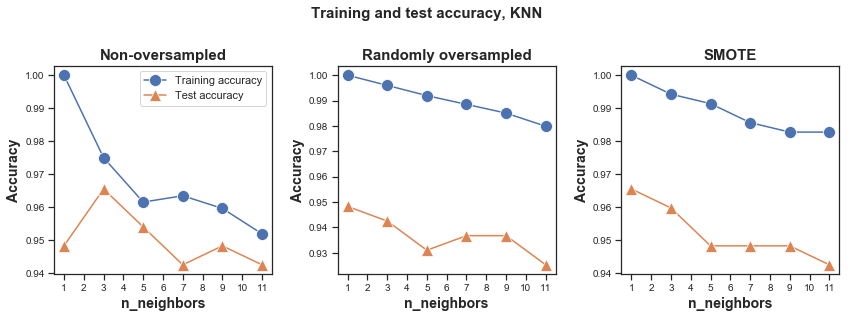

In [95]:
sns.set_style("ticks") #Shows tick marks on x and y axes.
fig, ax = plt.subplots(figsize=(12,4))

plt.subplot(1,3,1)
ax = sns.lineplot(x=neighbors, y=training_accuracy, linewidth=1.5, marker='o', ms=12)
sns.lineplot(x=neighbors, y=test_accuracy, linewidth=1.5, marker='^', ms=12)
ax.set_title('Non-oversampled', fontsize=15, weight='bold')
ax.set_ylabel('Accuracy', fontsize=14,weight='bold')
ax.set_xlabel('n_neighbors', fontsize=14, weight='bold')
ax.tick_params(labelsize=10)
ax.legend(handles=ax.lines, labels=['Training accuracy', 'Test accuracy'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

##Oversampled data
plt.subplot(1,3,2)
ax1 = sns.lineplot(x=neighbors, y=training_accuracy_OS, linewidth=1.5, marker='o', ms=12)
sns.lineplot(x=neighbors, y=test_accuracy_OS, linewidth=1.5, marker='^', ms=12)
ax1.set_title('Randomly oversampled', fontsize=15, weight='bold')
ax1.set_ylabel('Accuracy', fontsize=14, weight='bold')
ax1.set_xlabel('n_neighbors', fontsize=14, weight='bold')
ax1.tick_params(labelsize=10)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

##SMOTE data
plt.subplot(1,3,3)
ax2 = sns.lineplot(x=neighbors, y=training_accuracy_SM, linewidth=1.5, marker='o', ms=12)
sns.lineplot(x=neighbors, y=test_accuracy_SM, linewidth=1.5, marker='^', ms=12)
ax2.set_title('SMOTE', fontsize=15, weight='bold')
ax2.set_ylabel('Accuracy', fontsize=14, weight='bold')
ax2.set_xlabel('n_neighbors', fontsize=14, weight='bold')
ax2.tick_params(labelsize=10)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.suptitle('Training and test accuracy, KNN', fontsize=15, weight='bold', y=1.1)
plt.tight_layout()
plt.show()
# plt.savefig('KNN_accuracy_n_neighbors.png')

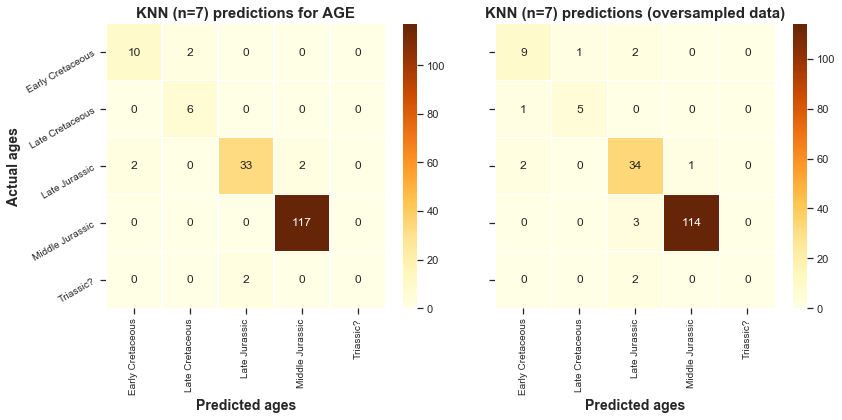

In [97]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
y_pred = knn.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,6))

plt.subplot(1,2,1)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=14, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=14, weight='bold')
ax.set_title('KNN (n=7) predictions for AGE', fontsize=15, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=10)

#Over-sampled data
plt.subplot(1,2,2)
knn1 = knn
knn1.fit(X_resampled, y_resampled)
y_pred1 = knn1.predict(x_test)

conf_mat1 = confusion_matrix(y_test, y_pred1)

ax1 = sns.heatmap(conf_mat1, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                 xticklabels=labels)
ax1.set_xlabel('Predicted ages', fontsize=14, weight='bold')
ax1.set_title('KNN (n=7) predictions (oversampled data)', fontsize=15, weight='bold')
ax1.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax1.set_yticklabels('')
ax1.tick_params(labelsize=10)

plt.tight_layout()
plt.show()
# plt.savefig('KNN_predictions_heatmap_AGE.png',dpi=400,bbox_inches='tight')

In [98]:
'''
Calculate precision and recall of KNN models
'''
print('Classification report for KNN of raw data:\n') 
print(classification_report(y_test, y_pred, target_names=labels))
print('\n\nClassification report for KNN of oversampled data:\n')
print(classification_report(y_test, y_pred1, target_names=labels))

Classification report for KNN of raw data:

                  precision    recall  f1-score   support

Early Cretaceous       0.83      0.83      0.83        12
 Late Cretaceous       0.75      1.00      0.86         6
   Late Jurassic       0.94      0.89      0.92        37
 Middle Jurassic       0.98      1.00      0.99       117
       Triassic?       0.00      0.00      0.00         2

       micro avg       0.95      0.95      0.95       174
       macro avg       0.70      0.75      0.72       174
    weighted avg       0.94      0.95      0.95       174



Classification report for KNN of oversampled data:

                  precision    recall  f1-score   support

Early Cretaceous       0.75      0.75      0.75        12
 Late Cretaceous       0.83      0.83      0.83         6
   Late Jurassic       0.83      0.92      0.87        37
 Middle Jurassic       0.99      0.97      0.98       117
       Triassic?       0.00      0.00      0.00         2

       micro avg       0.93

KNN with 7 neighbors seems to be the best model that avoids overfitting. The performance with oversampling improves sensitivity to minority classes. SMOTE data just overfits and the shape of the data is presumably not a natural fit for KNN. Oversampling degrades slightly the performance on the majority classes so both non-oversampled and oversampled datasets have the same overall test accuracy.

In [44]:
##Predict against all X
# y_pred_knn = knn.predict(X)
# info['KNN_predictions'] = y_pred_knn

In [3]:
'''
Concatenate the info file with all the predictions from clusters and models with the data df.
'''
# volve_full = pd.concat([info,X], axis=1)
#list(volve_full.columns)
#volve_full.to_csv('volve_full_predictions.csv')

##If starting a fresh session, load the df:
volve_full = pd.read_csv('volve_full_predictions.csv')

# ##list(volve_stages.columns)
volve_full.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1,inplace=True)

info = volve_full.iloc[:,:33] #info df of PCoA and predictions etc.
data = volve_full.iloc[:,33:] #data df of fossil features already scaled with Hellinger transformation.vvvvvvvv

### Model summary:

The results of tuning the models shows that the single **most powerful model is the SVC** that works as effectively on the raw (i.e. not oversampled) data as it does with increasing the training set artificially. It's unlikely that ensembling will work any better in this instance. In keeping with all the models, it does misclassify some of the Late Jurassic samples. What are these samples and why doesn't it work well to classify them?

In [49]:
mismatch_svc = info.loc[(info['AGE'])!= (info['SVC_predictions'])]
mismatch_svc.head()

,AGE,STAGE,FORMATION,ZONE,BASE,TYPE,ANALYST,SITE,LABEL,N,...,RFC_predictions,GB_predictions,LR_predictions,SVC_predictions,KNN_predictions,Early_K_prob_SVC,Late_K_prob_SVC,Late_J_prob_SVC,Middle_J_prob_SVC,Triassic?_prob_SVC
29,Triassic?,Indet,Unassigned,Unassigned,3534.0,CU,BioStrat,F1,N15_9_F_01_45,47,...,Middle Jurassic,Middle Jurassic,Middle Jurassic,Late Jurassic,Late Jurassic,0.027101,0.022713,0.398913,0.062597,0.488676
539,Early Cretaceous,Late Albian,Rodby,PK28,3340.0,CU,BioStrat,F15B,N15_9_F15B_05,189,...,Late Cretaceous,Late Cretaceous,Late Cretaceous,Late Cretaceous,Late Cretaceous,0.568690,0.392575,0.019765,0.009981,0.008989


Inspecting the mismatched samples with the master df indicates that they don't have any unusal or obvious characteristics (e.g. low count sizes or very uneven). Two of the samples are immediately below (10 feet) 'Early Cretaceous' samples and are the next sample run in order. This is a red-flag.

__The samples are likely contaminated by caved material__ or are misclassified by the consultants. Latest Jurassic and Earliest Cretaceous fossil assemblages are also difficult to assign to ages since they look similar. Hence, likely this is a failure *of the data, and not the modelling*. Test this by plotting against PCoA axes.

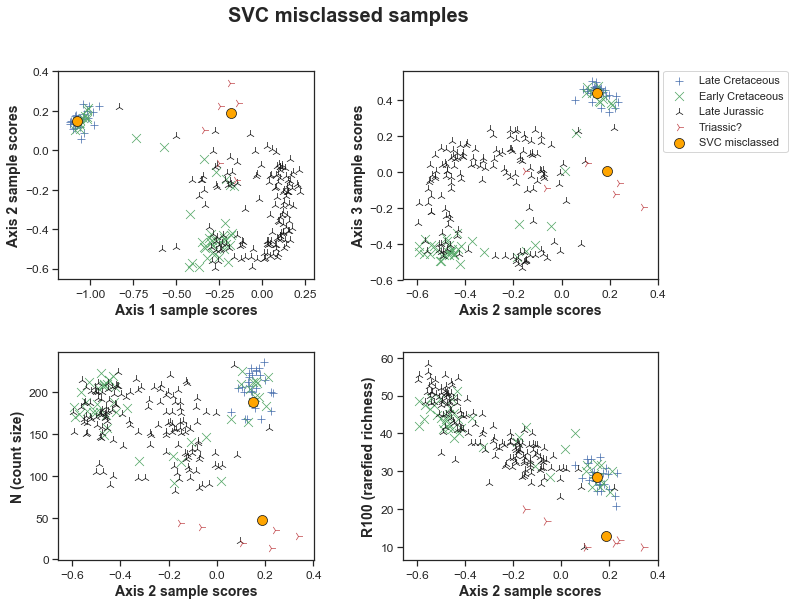

In [50]:
'''
What do the misclassified data look like plotted against PCoA scores? Are they compositionally odd i.e. contaminated?
'''
## Subset younger strata information. Contamination will occur from younger --> older samples.
late_jur = info.loc[(info['AGE'] == 'Late Jurassic')]
early_cret = info.loc[(info['AGE'] == 'Early Cretaceous')]
late_cret = info.loc[(info['AGE'] == 'Late Cretaceous')]
triassic = info.loc[(info['AGE'] == 'Triassic?')]

#set-up plotting parameters.
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(10.75,9))

##Plot axis 1 vs. 2 against misclassed samples
plt.subplot(221)
ax1 = sns.scatterplot(x='AXIS_1', y='AXIS_2', data=late_cret, alpha=1, s=80,
                      marker='+',color='b')
ax2 = sns.scatterplot(x='AXIS_1', y='AXIS_2', data=early_cret, alpha=1, s=80,
                      marker='x',color='g')
ax3 = sns.scatterplot(x='AXIS_1', y='AXIS_2', data=late_jur, alpha=1, s=80, 
                      marker='2',color='k')
ax4 = sns.scatterplot(x='AXIS_1', y='AXIS_2', data=triassic, alpha=1, s=80, 
                      marker='4',color='r')
ax5 = sns.scatterplot(x='AXIS_1', y='AXIS_2', data=mismatch_svc,alpha=1, s=100,
                      color='orange', edgecolor='k')
ax1.set_ylabel('Axis 2 sample scores', fontsize=14, weight='bold')
ax1.set_xlabel('Axis 1 sample scores', fontsize=14, weight='bold')
ax1.tick_params(labelsize=12)

##plot axes 2 and 3 against misclassed points
plt.subplot(222)
ax1 = sns.scatterplot(x='AXIS_2', y='AXIS_3', data=late_cret, alpha=1, s=80,
                      marker='+',color='b',label='Late Cretaceous')
ax2 = sns.scatterplot(x='AXIS_2', y='AXIS_3', data=early_cret, alpha=1, s=80,
                      marker='x',color='g', label='Early Cretaceous')
ax3 = sns.scatterplot(x='AXIS_2', y='AXIS_3', data=late_jur, alpha=1, s=80,
                      marker='2',color='k',label='Late Jurassic')
ax4 = sns.scatterplot(x='AXIS_2', y='AXIS_3', data=triassic, alpha=1, s=80, 
                      marker='4',color='r', label='Triassic?')
ax5 = sns.scatterplot(x='AXIS_2', y='AXIS_3', data=mismatch_svc,alpha=1, s=100,
                      color='orange', edgecolor='k',label='SVC misclassed')
plt.legend(bbox_to_anchor=(1.02, 1),loc=2, borderaxespad=0.) 
ax1.set_ylabel('Axis 3 sample scores', fontsize=14, weight='bold')
ax1.set_xlabel('Axis 2 sample scores', fontsize=14, weight='bold')
ax1.tick_params(labelsize=12)

##plot axes 2 and N against misclassed points
plt.subplot(223)
ax1 = sns.scatterplot(x='AXIS_2', y='N', data=late_cret, alpha=1,s=80,
                      marker='+',color='b')
ax2 = sns.scatterplot(x='AXIS_2', y='N', data=early_cret, alpha=1, s=80,
                      marker='x',color='g')
ax3 = sns.scatterplot(x='AXIS_2', y='N', data=late_jur, alpha=1, s=80,
                      marker='2',color='k')
ax4 = sns.scatterplot(x='AXIS_2', y='N', data=triassic, alpha=1, s=80,
                      marker='4',color='r')
ax5 = sns.scatterplot(x='AXIS_2', y='N', data=mismatch_svc,alpha=1, s=100,
                      color='orange', edgecolor='k')
ax1.set_ylabel('N (count size)', fontsize=14, weight='bold')
ax1.set_xlabel('Axis 2 sample scores', fontsize=14, weight='bold')
ax1.tick_params(labelsize=12)

##plot axes 2 and R100 against misclassed points
plt.subplot(224)
ax1 = sns.scatterplot(x='AXIS_2', y='R100', data=late_cret, alpha=1,s=80,
                      marker='+',color='b')
ax2 = sns.scatterplot(x='AXIS_2', y='R100', data=early_cret, alpha=1, s=80,
                      marker='x',color='g')
ax3 = sns.scatterplot(x='AXIS_2', y='R100', data=late_jur, alpha=1, s=80,
                      marker='2',color='k')
ax4 = sns.scatterplot(x='AXIS_2', y='R100', data=triassic,alpha=1, s=100,
                      marker='4',color='r')
ax5 = sns.scatterplot(x='AXIS_2', y='R100', data=mismatch_svc,alpha=1, s=100,
                      color='orange', edgecolor='k')
ax1.set_ylabel('R100 (rarefied richness)', fontsize=14, weight='bold')
ax1.set_xlabel('Axis 2 sample scores', fontsize=14, weight='bold')
ax1.tick_params(labelsize=12)


plt.suptitle('SVC misclassed samples', fontsize=20, weight='bold')
plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.show()
# plt.savefig('svc_misclassed_pcoa_r100_n.png',dpi=400,bbox_inches='tight')

The results of the misclassed samples plotted against PCoA (a proxy for sample composition) indicates that __one sample is strongly associated with Late Cretaceous samples__ as well as some Early Cretaceous and is therefore highly likely to contain caved material or is misclassed by the analysts. The mismatch of the second might be due to caving but the link is less obvious since it plots with other Triassic? samples. Most of the classifiers put this sample with the Middle Jurassic set.

These misclassed samples are not from Ichron, that has contributed the minor number of samples to the dataset, but from BioStrat Ltd. Therefore it's unlikely that the error is through different taxonomy or other analyst-bias in the minority sample cases from Ichron.

__Interpretation__: Caving and analyst error.

In [65]:
'''
Get predicted probabilities for the SVC 
'''
#Assign probabilities to an object. Make sure probabilities=True for the SVC in code above.
misclassed = svc.predict_proba(X)

#Check class order of the array
print(svc.classes_)

#Make into columns of the info df
info['Early_K_prob_SVC'] = misclassed[:,0]
info['Late_K_prob_SVC'] = misclassed[:,1]
info['Late_J_prob_SVC'] = misclassed[:,2]
info['Middle_J_prob_SVC'] = misclassed[:,3]
info['Triassic?_prob_SVC'] = misclassed[:,4]

'''
Concatenate the info file with all the predictions from clusters and models with the data df.
'''
#volve_full = pd.concat([info,X], axis=1)
#list(volve_full.columns)
#volve_full.to_csv('volve_full_predictions.csv')

['Early Cretaceous' 'Late Cretaceous' 'Late Jurassic' 'Middle Jurassic'
 'Triassic?']


In [117]:
'''
What are the probabilities from SVC for the misclassed samples?
'''
probs = mismatch_svc[['AGE','Early_K_prob_SVC', 'Late_K_prob_SVC','Late_J_prob_SVC','Middle_J_prob_SVC','Triassic?_prob_SVC']]

probs_t = probs.T #transpose df
probs_t = probs_t.rename(columns=probs_t.iloc[0])
probs_t = probs_t.iloc[1:]
print(probs_t)

                    Triassic? Early Cretaceous
Early_K_prob_SVC    0.0271014          0.56869
Late_K_prob_SVC     0.0227135         0.392575
Late_J_prob_SVC      0.398913        0.0197647
Middle_J_prob_SVC   0.0625966        0.0099806
Triassic?_prob_SVC   0.488676       0.00898937


### How does SVC perform on just the PCoA axes?

These represent c. 20% of the variance. But they are already centred and potentially more useful than just the fossil fatures.

In [99]:
X = info[['AXIS_1','AXIS_2','AXIS_3']]
Y = info['AGE']

X_train, x_test, Y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=45, stratify=Y)

In [100]:
print('\nOriginal data: \n',sorted(Counter(Y_train).items()))


Original data: 
 [('Early Cretaceous', 31), ('Late Cretaceous', 14), ('Late Jurassic', 92), ('Middle Jurassic', 348), ('Triassic?', 5)]


In [101]:
##Generate a list of labels for the heatmaps (these are sorted alphabetically, so sort them here)

labels = []
items = sorted(Counter(Y_train).items())

for label, value in items:
     labels.append(label)
    
print(labels)

['Early Cretaceous', 'Late Cretaceous', 'Late Jurassic', 'Middle Jurassic', 'Triassic?']


In [7]:
'''
Tune the SVM
'''

param_grid = {'C':[0.001, 0.01, 0.1, 1, 10],
             'gamma': [0.001,0.01, 0.1, 1, 10],
             'kernel': ['rbf', 'linear', 'poly']}
#do in a log series (a convention).NB: Changing penalties doesn't alter CV score.

grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=4)
grid.fit(X_train,Y_train)

print('Best cross-validation score (no oversampling) SVC: {:.2f}'.format(grid.best_score_))
print('Best parameters (no oversampling) SVC: ', grid.best_params_)

Best cross-validation score (no oversampling) SVC: 0.88
Best parameters (no oversampling) SVC:  {'gamma': 10, 'C': 1, 'kernel': 'rbf'}


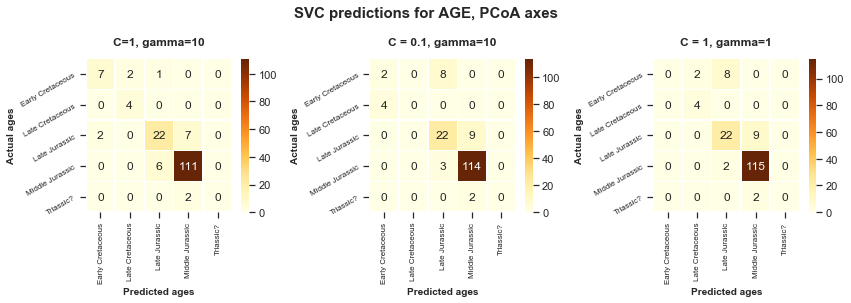

In [102]:
svc = SVC(C=1, gamma=10,kernel='rbf', probability=True, random_state=45) #set probability to True to get predict_probab()
svc.fit(X_train, Y_train)
y_pred = svc.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,4))

plt.subplot(131)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=10, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax.set_title('C=1, gamma=10', fontsize=12, weight='bold', y=1.05)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=8)

## Change the C parameter to reduce the fit. Does this actually do anything.
svc = SVC(C=0.1, gamma=10,kernel='rbf', probability=True, random_state=45) #set probability to True to get predict_probab()
svc.fit(X_train, Y_train)
y_pred1 = svc.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred1)

plt.subplot(132)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=10, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax.set_title('C = 0.1, gamma=10', fontsize=12, weight='bold', y=1.05)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=8)

## Change the C parameter to reduce the fit. Does this actually do anything.
svc = SVC(C=1, gamma=1,kernel='rbf', probability=True, random_state=45) #set probability to True to get predict_probab()
svc.fit(X_train, Y_train)
y_pred1 = svc.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred1)

plt.subplot(133)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=10, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=10, weight='bold')
ax.set_title('C = 1, gamma=1', fontsize=12, weight='bold', y=1.05)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=8)

plt.suptitle('SVC predictions for AGE, PCoA axes', fontsize='15', weight='bold', y=1.05)
plt.tight_layout()
plt.show()

# plt.savefig('SVC_prediction_heatmaps_AGE_PCoA.png',dpi=400,bbox_inches='tight')

In [17]:
'''
Calculate precision and recall of SVC models
'''
print('Classification report for SVC of raw data:\n') #SMOTE will be identical
print(classification_report(y_test, y_pred, target_names=labels))

Classification report for SVC of raw data:

                  precision    recall  f1-score   support

Early Cretaceous       0.53      0.67      0.59        12
 Late Cretaceous       0.67      1.00      0.80         6
   Late Jurassic       0.82      0.73      0.77        37
 Middle Jurassic       0.96      0.96      0.96       117
       Triassic?       0.00      0.00      0.00         2

       micro avg       0.88      0.88      0.88       174
       macro avg       0.60      0.67      0.62       174
    weighted avg       0.88      0.88      0.88       174



The SVC performs worse on the reduced dataset which is intuitive if the amount of variance explained is only c. 20% by the PCoA axes. 

## 4.2. Modelling 'STAGE'

This will be potentially, and incrementally, more difficult. There are 1) fewer samples for each group, 2) subtler contrasts between classes because there is less time between them (samples close together in time will be more alike. It's a tenet of Darwinian theory and generally holds true), 3) following from 2, the higher-resolution your time-step, the more likely complications arise because the data classes are treated as discrete bins rather than a time-series. In practice this works, but in reality the *change of composition over time is continous*. Therefore, there may be more misclassification near boundaries between stages.

In [106]:
##If starting a fresh session, load the df:
volve_full = pd.read_csv('volve_full_predictions.csv')
# volve.head()

In [107]:
##Drop the rows with singletone classes in the AGE column
volve_stages = volve_full.groupby('STAGE').filter(lambda x: len(x) >= 6).reset_index(drop=True) #filter rows based on condition.
volve_stages['STAGE'].value_counts() #check correctly implemented

##list(volve_stages.columns)
volve_stages.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1,inplace=True)

info = volve_stages.iloc[:,:34] #info df of PCoA and predictions etc.
data = volve_stages.iloc[:,34:] #data df of fossil features already scaled with Hellinger transformation.

In [110]:
#from sklearn.model_selection import train_test_split
X = data
Y = info['STAGE']

X_train, x_test, Y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=45, stratify=Y)

In [111]:
print('Y_train labels:\n\n{}'.format(Y_train.value_counts().sort_index()))
print('\ny_test labels:\n\n{}'.format(y_test.value_counts().sort_index()))

Y_train labels:

Early Berriasian           22
Early Oxfordian            11
Early-Late Kimmeridgian     5
Early-Mid Callovian         8
Early-Mid Cenomanian       14
Early?-Mid Oxfordian        8
Indet                       5
Late Albian                 9
Late Callovian             86
Late Callovian?            14
Late Oxfordian             17
Late Tithonian             15
Mid Callovian              99
Mid Callovian?             29
Mid Oxfordian              28
Mid Tithonian               8
Mid-Late Callovian         49
Mid-Late Callovian?        53
Mid?-Late Callovian        10
Name: STAGE, dtype: int64

y_test labels:

Early Berriasian            7
Early Oxfordian             4
Early-Late Kimmeridgian     2
Early-Mid Callovian         3
Early-Mid Cenomanian        4
Early?-Mid Oxfordian        3
Indet                       2
Late Albian                 3
Late Callovian             29
Late Callovian?             5
Late Oxfordian              5
Late Tithonian              5
Mid Callov

In [112]:
'''
Randomly oversample the data in case this improves the training of the models.
Since the smallest training class contains only 5 samples, this may generate more 
noise rather than robust training samples. The baseline performance of the training data
will be compared with the oversampled data. Drop SMOTE based on previous performance.
'''

## Randomly over-sampling data.
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=45)
X_resampled, y_resampled = ros.fit_resample(X_train, Y_train)

## Randomly under-sampling data.
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=45)
X_unsampled, y_unsampled = rus.fit_resample(X_train, Y_train)


from collections import Counter
print('\nOriginal data: \n',sorted(Counter(Y_train).items()))
print('\nRandomly oversampled data: \n', sorted(Counter(y_resampled).items()))
print('\nRandomly undersampled data: \n', sorted(Counter(y_unsampled).items()))


Original data: 
 [('Early Berriasian', 22), ('Early Oxfordian', 11), ('Early-Late Kimmeridgian', 5), ('Early-Mid Callovian', 8), ('Early-Mid Cenomanian', 14), ('Early?-Mid Oxfordian', 8), ('Indet', 5), ('Late Albian', 9), ('Late Callovian', 86), ('Late Callovian?', 14), ('Late Oxfordian', 17), ('Late Tithonian', 15), ('Mid Callovian', 99), ('Mid Callovian?', 29), ('Mid Oxfordian', 28), ('Mid Tithonian', 8), ('Mid-Late Callovian', 49), ('Mid-Late Callovian?', 53), ('Mid?-Late Callovian', 10)]

Randomly oversampled data: 
 [('Early Berriasian', 99), ('Early Oxfordian', 99), ('Early-Late Kimmeridgian', 99), ('Early-Mid Callovian', 99), ('Early-Mid Cenomanian', 99), ('Early?-Mid Oxfordian', 99), ('Indet', 99), ('Late Albian', 99), ('Late Callovian', 99), ('Late Callovian?', 99), ('Late Oxfordian', 99), ('Late Tithonian', 99), ('Mid Callovian', 99), ('Mid Callovian?', 99), ('Mid Oxfordian', 99), ('Mid Tithonian', 99), ('Mid-Late Callovian', 99), ('Mid-Late Callovian?', 99), ('Mid?-Late Cal

In [113]:
##Generate a list of labels for the heatmaps (these are sorted alphabetically, so sort them here)

labels = []
items = sorted(Counter(Y_train).items())

for label, value in items:
     labels.append(label)
    
print(labels)

['Early Berriasian', 'Early Oxfordian', 'Early-Late Kimmeridgian', 'Early-Mid Callovian', 'Early-Mid Cenomanian', 'Early?-Mid Oxfordian', 'Indet', 'Late Albian', 'Late Callovian', 'Late Callovian?', 'Late Oxfordian', 'Late Tithonian', 'Mid Callovian', 'Mid Callovian?', 'Mid Oxfordian', 'Mid Tithonian', 'Mid-Late Callovian', 'Mid-Late Callovian?', 'Mid?-Late Callovian']


### Support Vector Machine

In [26]:
'''
Tune the SVM: Since this is the strongest performer on the data so far, start with this first.
'''

param_grid = {'C':[0.0001, 0.001, 0.01, 0.1],
             'gamma': [0.1,1, 10,100],
             'kernel': ['rbf','poly']}
#parameters changed iteratively 

grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=4)
grid.fit(X_train,Y_train)

print('Best cross-validation score (no oversampling) SVC: {:.2f}'.format(grid.best_score_))
print('Best parameters (no oversampling) SVC: ', grid.best_params_)

Best cross-validation score (no oversampling) SVC: 0.79
Best parameters (no oversampling) SVC:  {'gamma': 100, 'C': 0.0001, 'kernel': 'poly'}


In [132]:
##Randomly oversampled data:

grid.fit(X_resampled, y_resampled)
print('Best cross-validation score (Oversampled) SVC: {:.2f}'.format(grid.best_score_))
print('Best parameters (Oversampled) SVC: ', grid.best_params_)

Best cross-validation score (Oversampled) SVC: 0.97
Best parameters (Oversampled) SVC:  {'gamma': 100, 'kernel': 'poly', 'C': 0.0001}


In [27]:
##Randomly undersampled data:

grid.fit(X_unsampled, y_unsampled)
print('Best cross-validation score (Oversampled) SVC: {:.2f}'.format(grid.best_score_))
print('Best parameters (Oversampled) SVC: ', grid.best_params_)

Best cross-validation score (Oversampled) SVC: 0.75
Best parameters (Oversampled) SVC:  {'gamma': 100, 'C': 0.0001, 'kernel': 'poly'}


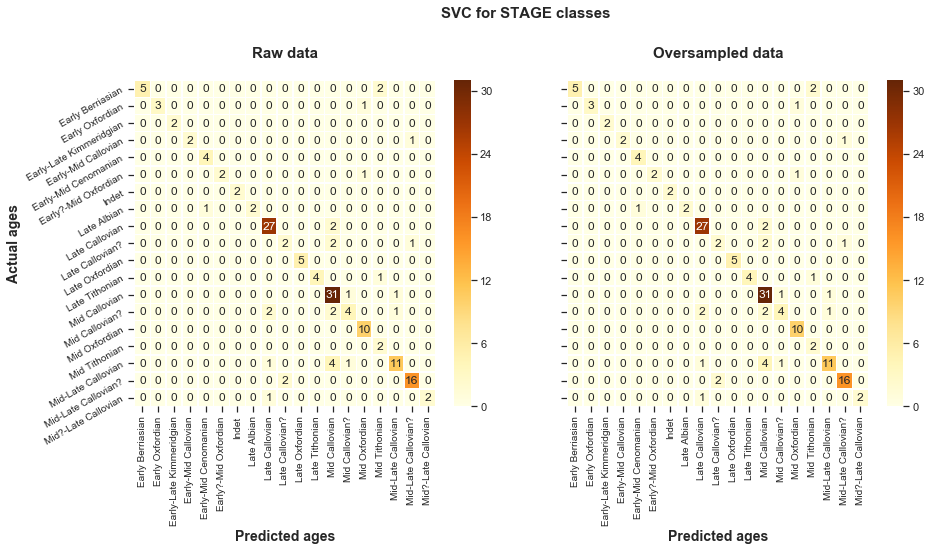

In [114]:
svc = SVC(C=0.0001, gamma=100,kernel='poly', probability=True, random_state=45)
svc.fit(X_train, Y_train)
y_pred = svc.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(14.5,6))

plt.subplot(121)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=14, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=14, weight='bold')
ax.set_title('Raw data', fontsize=15, weight='bold', y=1.05)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=10)

#Over-sampled data
plt.subplot(122)
svc1 = svc
svc1.fit(X_resampled, y_resampled)
y_pred1 = svc1.predict(x_test)

conf_mat1 = confusion_matrix(y_test, y_pred1)

ax1 = sns.heatmap(conf_mat1, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                 xticklabels=labels)
ax1.set_xlabel('Predicted ages', fontsize=14, weight='bold')
ax1.set_title('Oversampled data', fontsize=15, weight='bold', y=1.05)
ax1.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax1.set_yticklabels('')
ax1.tick_params(labelsize=10)

plt.suptitle('SVC for STAGE classes', fontsize=15, weight='bold', y=1.05)
plt.subplots_adjust(wspace=0.15)
plt.show()
# plt.savefig('SVC_prediction_heatmaps_stages.png',dpi=400,bbox_inches='tight')

In [73]:
'''
How do these different treatments of the data perform with tuned SVC models? 
The GridSearch will provide a possibly overfit model since it seeks the best model.
'''
svc2 = svc
svc2.fit(X_unsampled, y_unsampled)
y_pred2 = svc2.predict(x_test)

'''
Calculate precision and recall of SVC models
'''
print('Classification report for SVC of raw data:\n') 
print(classification_report(y_test, y_pred, target_names=labels))
print('\n\nClassification report for SVC of oversampled data:\n')
print(classification_report(y_test, y_pred1, target_names=labels))
print('\n\nClassification report for SVC of undersampled data:\n')
print(classification_report(y_test, y_pred2, target_names=labels))

Classification report for SVC of raw data:

                         precision    recall  f1-score   support

       Early Berriasian       1.00      0.71      0.83         7
        Early Oxfordian       1.00      0.75      0.86         4
Early-Late Kimmeridgian       1.00      1.00      1.00         2
    Early-Mid Callovian       1.00      0.67      0.80         3
   Early-Mid Cenomanian       0.80      1.00      0.89         4
   Early?-Mid Oxfordian       1.00      0.67      0.80         3
                  Indet       1.00      1.00      1.00         2
            Late Albian       1.00      0.67      0.80         3
         Late Callovian       0.87      0.93      0.90        29
        Late Callovian?       0.50      0.40      0.44         5
         Late Oxfordian       1.00      1.00      1.00         5
         Late Tithonian       1.00      0.80      0.89         5
          Mid Callovian       0.76      0.94      0.84        33
         Mid Callovian?       0.67      0.44 

It appears that the model does a reasonable job fitting to the data if the raw values ot oversampling are used. Clearly the under-sampling leads to a poor model - the data are too variable for 5 samples to characterise a class. At a quick glance for the better performing SVC models, some of the misclassifications are 'near-misses' - the misclassification is a geological stage adjacent to the actual stage. Some of the classes are vague or questionable and could be lumped. Examples are:
* Mid?-Late Callovian
* Mid-Late Callovian?
* Mid Callovian
* Mid Callovian?
* Late Callovian?

Some of the errors are in terminology and some will be down-well contamination. CV shows that there are wide discrepancies in the scores that indicates a relatively weak underlying model.

**Find the best parameters for 2 other contrasting models to try an ensemble approach.** Based in previous attempts, try LR and RFC.

### Logistic regression

In [30]:
'''
Tune the Logistic regression.
'''

param_grid = {'C':[0.01,0.1, 1, 10, 100,1000]}

grid = GridSearchCV(LogisticRegression(solver='lbfgs', multi_class='multinomial'), param_grid, cv=5, n_jobs=4)
grid.fit(X_train,Y_train)

print('Best cross-validation score (no oversampling) LR: {:.2f}'.format(grid.best_score_))
print('Best parameters (no oversampling) LR: ', grid.best_params_)

Best cross-validation score (no oversampling) LR: 0.72
Best parameters (no oversampling) LR:  {'C': 10}


In [31]:
##Randomly oversampled data:

grid.fit(X_resampled, y_resampled)
print('Best cross-validation score (Oversampled) LR: {:.2f}'.format(grid.best_score_))
print('Best parameters (Oversampled) LR: ', grid.best_params_)

## This results in a very high C! Consider reducing this if model overfits.

Best cross-validation score (Oversampled) LR: 0.96
Best parameters (Oversampled) LR:  {'C': 1000}


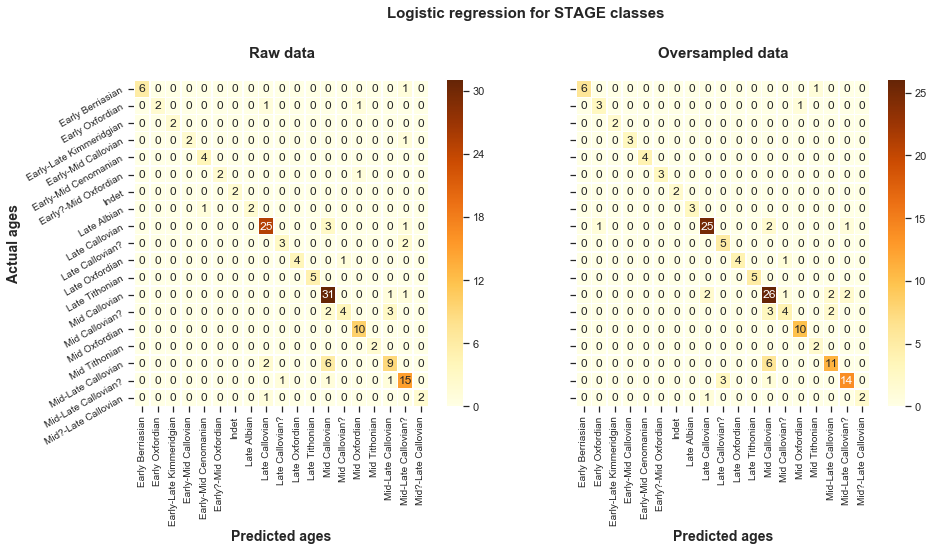

In [115]:
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial',C=10, random_state=45)
lr.fit(X_train, Y_train)
y_pred = lr.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(14.5,6))

plt.subplot(121)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=14, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=14, weight='bold')
ax.set_title('Raw data', fontsize=15, weight='bold', y=1.05)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=10)

#Over-sampled data
plt.subplot(122)
lr1 = LogisticRegression(solver='lbfgs', multi_class='multinomial',C=1000, random_state=45)
lr1.fit(X_resampled, y_resampled)
y_pred1 = lr1.predict(x_test)

conf_mat1 = confusion_matrix(y_test, y_pred1)

ax1 = sns.heatmap(conf_mat1, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                 xticklabels=labels)
ax1.set_xlabel('Predicted ages', fontsize=14, weight='bold')
ax1.set_title('Oversampled data', fontsize=15, weight='bold', y=1.05)
ax1.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax1.set_yticklabels('')
ax1.tick_params(labelsize=10)

plt.suptitle('Logistic regression for STAGE classes', fontsize=15, weight='bold', y=1.05)
plt.subplots_adjust(wspace=0.2)
plt.show()
# plt.savefig('LR_prediction_heatmaps_stages.png',dpi=400,bbox_inches='tight')

In [33]:
print('Classification report for LR of raw data:\n') 
print(classification_report(y_test, y_pred, target_names=labels))
print('\n\nClassification report for LR of oversampled data:\n')
print(classification_report(y_test, y_pred1, target_names=labels))

Classification report for LR of raw data:

                         precision    recall  f1-score   support

       Early Berriasian       1.00      0.86      0.92         7
        Early Oxfordian       1.00      0.50      0.67         4
Early-Late Kimmeridgian       1.00      1.00      1.00         2
    Early-Mid Callovian       1.00      0.67      0.80         3
   Early-Mid Cenomanian       0.80      1.00      0.89         4
   Early?-Mid Oxfordian       1.00      0.67      0.80         3
                  Indet       1.00      1.00      1.00         2
            Late Albian       1.00      0.67      0.80         3
         Late Callovian       0.86      0.86      0.86        29
        Late Callovian?       0.75      0.60      0.67         5
         Late Oxfordian       1.00      0.80      0.89         5
         Late Tithonian       1.00      1.00      1.00         5
          Mid Callovian       0.72      0.94      0.82        33
         Mid Callovian?       0.80      0.44  

The GridSearch yields very high values for C that could lead to overfitting. However, when applied to the test data, the models perfom well without showing extreme fit. The confusion matrices demonstrate some good model performance and also some errors. This is tabulated by the precision and recall. Oversampled data provides a slightly better model performance overall.

### Random Forest 

In [34]:
'''
Tune the Random forest classifier
'''
##Tune parameters for Random Forest Classifier
param_grid = {'n_estimators':[50, 100, 150, 200, 250],
             'max_depth': [5, 10, 15, 20, 25]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=4)
grid.fit(X_train,Y_train)

print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross-validation score: 0.72
Best parameters:  {'n_estimators': 250, 'max_depth': 25}


In [35]:
##Randomly oversampled data:

grid.fit(X_resampled, y_resampled)
print('Best cross-validation score (Oversampled) RFC: {:.2f}'.format(grid.best_score_))
print('Best parameters (Oversampled) RFC: ', grid.best_params_)

Best cross-validation score (Oversampled) RFC: 0.97
Best parameters (Oversampled) RFC:  {'n_estimators': 250, 'max_depth': 25}


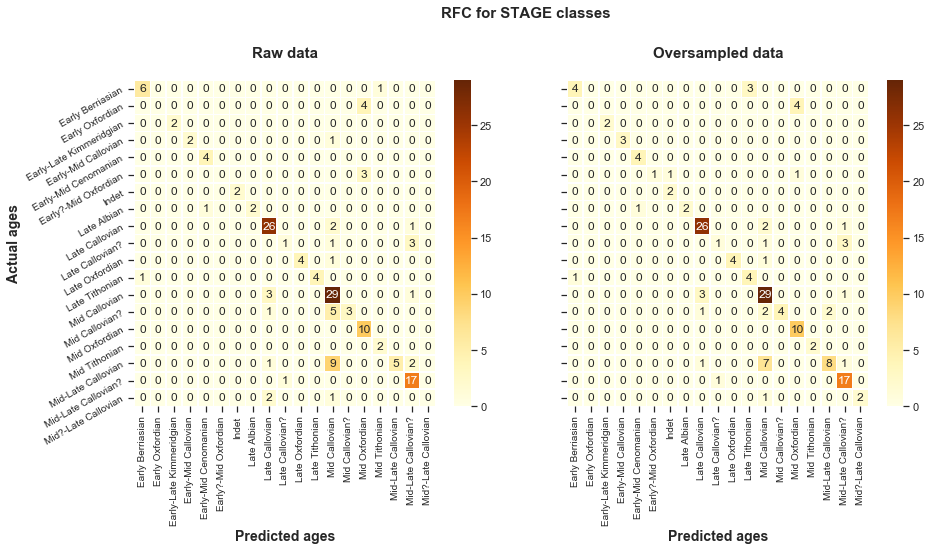

In [116]:
rfc = RandomForestClassifier(n_estimators=250, max_depth=25, random_state=45)
rfc.fit(X_train, Y_train)
y_pred = rfc.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(14.5,6))

plt.subplot(121)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr',
                xticklabels=labels)
ax.set_ylabel('Actual ages', fontsize=14, weight='bold')
ax.set_xlabel('Predicted ages', fontsize=14, weight='bold')
ax.set_title('Raw data', fontsize=15, weight='bold',y=1.05)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=10)

#Over-sampled data
plt.subplot(122)
rfc1 = RandomForestClassifier(n_estimators=250, max_depth=25, random_state=45)
rfc1.fit(X_resampled, y_resampled)
y_pred1 = rfc1.predict(x_test)

conf_mat1 = confusion_matrix(y_test, y_pred1)

ax1 = sns.heatmap(conf_mat1, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr', xticklabels=labels)
ax1.set_xlabel('Predicted ages', fontsize=14, weight='bold')
ax1.set_title('Oversampled data', fontsize=15, weight='bold', y=1.05)
ax1.set_yticklabels('')
ax1.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax1.tick_params(labelsize=10)

plt.suptitle('RFC for STAGE classes', fontsize=15, weight='bold',y=1.05)
plt.subplots_adjust(wspace=0.15)
plt.show()
# plt.savefig('RFC_prediction_heatmaps_stages.png',dpi=400,bbox_inches='tight')

In [117]:
print('Classification report for RFC of raw data:\n') 
print(classification_report(y_test, y_pred, target_names=labels))
print('\n\nClassification report for RFC of oversampled data:\n')
print(classification_report(y_test, y_pred1, target_names=labels))

Classification report for RFC of raw data:

                         precision    recall  f1-score   support

       Early Berriasian       0.86      0.86      0.86         7
        Early Oxfordian       0.00      0.00      0.00         4
Early-Late Kimmeridgian       1.00      1.00      1.00         2
    Early-Mid Callovian       1.00      0.67      0.80         3
   Early-Mid Cenomanian       0.80      1.00      0.89         4
   Early?-Mid Oxfordian       0.00      0.00      0.00         3
                  Indet       1.00      1.00      1.00         2
            Late Albian       1.00      0.67      0.80         3
         Late Callovian       0.79      0.90      0.84        29
        Late Callovian?       0.50      0.20      0.29         5
         Late Oxfordian       1.00      0.80      0.89         5
         Late Tithonian       1.00      0.80      0.89         5
          Mid Callovian       0.59      0.88      0.71        33
         Mid Callovian?       1.00      0.33 

The Random Forest Classifier performs reasonably well. It managed to classify the minority class successfully like the other models. Maybe this is a consequence of the unique proprties of this class rather than just its small size.

### Ensemble modelling

In [118]:
'''
Use the VotingClassifier to find a stronger model based on contrasting best-tuned models. Code adapted 
from Susan Li (2018) blog post to incorporate the VotingClassifier
'''
##Data with oversampling:

models = [rfc, svc, lr,
           VotingClassifier(estimators=[('RFC', rfc1),('SVC', svc1), ('LR', lr1)],
                            voting='hard')]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_resampled, y_resampled, scoring='accuracy', cv=CV, n_jobs=4)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name','fold_idx', 'accuracy'])


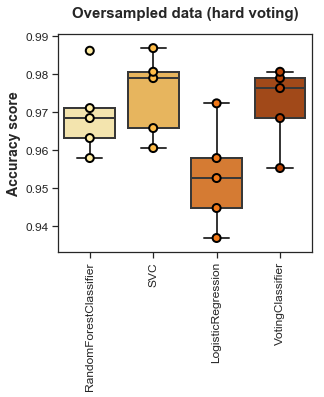

In [119]:
##Plot the results

fig, ax = plt.subplots(figsize=(10,4))
sns.set(style="ticks")

plt.subplot(121)
ax = sns.boxplot(x='model_name', y='accuracy', data=cv_df, palette='YlOrBr', linewidth=2)
ax = sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, 
                   jitter=False, edgecolor="black",linewidth=2, palette='YlOrBr')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.axes.set_title('Oversampled data (hard voting)',weight='bold', fontsize=15, y=1.05)
ax.set_ylabel('Accuracy score',fontsize=14, weight='bold')
ax.set_xlabel('')
ax.tick_params(labelsize=12)

plt.show()
# plt.savefig('Model_comparisons_training_data_ALL_models_oversampling.png',dpi=400,bbox_inches='tight')


In [120]:
##Check the accuracy of the models:

print('Mean of model CVs:\n \n' + str(cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False))
      + '\n\nSTD of model CVs: \n\n' + str(cv_df.groupby('model_name').accuracy.std().sort_values(ascending=False)))

Mean of model CVs:
 
model_name
SVC                       0.974543
VotingClassifier          0.971911
RandomForestClassifier    0.969335
LogisticRegression        0.952881
Name: accuracy, dtype: float64

STD of model CVs: 

model_name
LogisticRegression        0.013471
SVC                       0.010961
RandomForestClassifier    0.010672
VotingClassifier          0.010415
Name: accuracy, dtype: float64


The CV scores show disparity and a large IQR because the classes are imbalanced. Hard voting provides a higher CV score median and mean. The test will be how it performs against the test data.

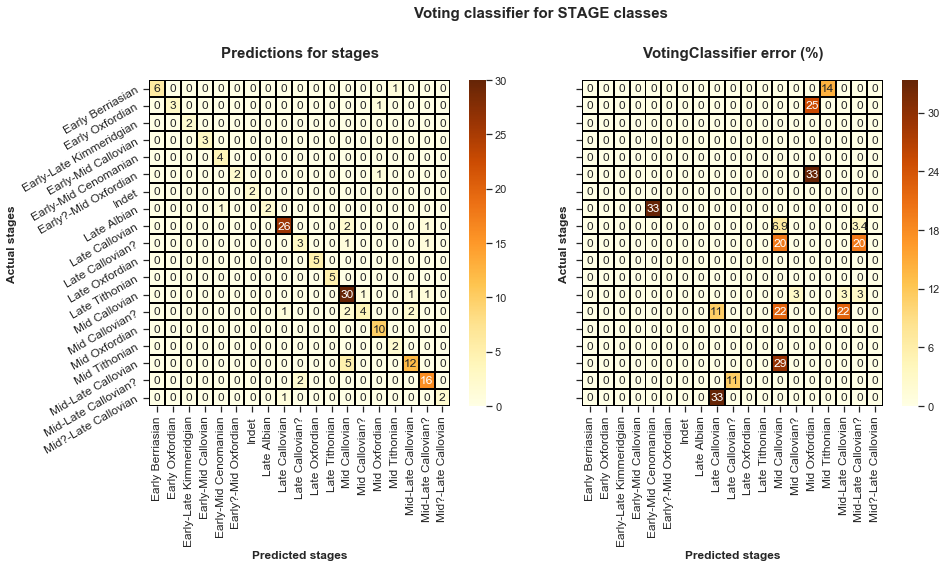

In [121]:
model_vc = VotingClassifier(estimators=[('LR', lr1),('RFC',rfc1),('SVC', svc1)],
                            voting='hard')

model_vc.fit(X_resampled, y_resampled)
y_pred_vc = model_vc.predict(x_test)
conf_mat_vc = confusion_matrix(y_test, y_pred_vc)

fig, ax = plt.subplots(figsize=(14.5,6))

plt.subplot(121)
ax = sns.heatmap(conf_mat_vc, annot=True, fmt='d', linewidths=0.5, cmap='YlOrBr', linewidth=1, linecolor='black',
                 xticklabels = labels, yticklabels=labels)
ax.set_ylabel('Actual stages', fontsize=12, weight='bold')
ax.set_xlabel('Predicted stages', fontsize=12, weight='bold')
ax.set_title('Predictions for stages', fontsize=15, weight='bold', y=1.05)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=12)

'''
Calculate the error rate of the voting classifier data predictions:
'''

row_sums = conf_mat_vc.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat_vc/row_sums*100

np.fill_diagonal(norm_conf_mat, 0)

plt.subplot(122)
ax = sns.heatmap(norm_conf_mat, annot=True, linewidths=0.5, cmap='YlOrBr', 
                 linewidth=1, linecolor='black',xticklabels=labels)
ax.set_ylabel('Actual stages', fontsize=12, weight='bold')
ax.set_xlabel('Predicted stages', fontsize=12, weight='bold')
ax.set_title('VotingClassifier error (%)', fontsize=15, weight='bold', y=1.05)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels('')
ax.set_yticklabels('')
ax.tick_params(labelsize=12)


plt.suptitle('Voting classifier for STAGE classes', fontsize=15, weight='bold',y=1.05)
plt.subplots_adjust(wspace=0.15)

# plt.savefig('Voting_classifier_confusion_matrix_oversampled_data_error.png',dpi=400,bbox_inches='tight')
plt.show()

In [122]:
'''
Calculate the error rate of the voting classifier data predictions:
'''
print('Classification report for VotingClassifier on oversampled data:\n') 
print(classification_report(y_test, y_pred_vc, target_names=labels))

Classification report for VotingClassifier on oversampled data:

                         precision    recall  f1-score   support

       Early Berriasian       1.00      0.86      0.92         7
        Early Oxfordian       1.00      0.75      0.86         4
Early-Late Kimmeridgian       1.00      1.00      1.00         2
    Early-Mid Callovian       1.00      1.00      1.00         3
   Early-Mid Cenomanian       0.80      1.00      0.89         4
   Early?-Mid Oxfordian       1.00      0.67      0.80         3
                  Indet       1.00      1.00      1.00         2
            Late Albian       1.00      0.67      0.80         3
         Late Callovian       0.93      0.90      0.91        29
        Late Callovian?       0.60      0.60      0.60         5
         Late Oxfordian       1.00      1.00      1.00         5
         Late Tithonian       1.00      1.00      1.00         5
          Mid Callovian       0.75      0.91      0.82        33
         Mid Callovian? 

The accuracy of the model is about 85% using the ensemble approach so it represents a 2% lift from just using the SVC alone. It still misclassifies some classes. These are stages that are geologically next to one another (e.g. Early Berriasian and Late Tithonian) or those with questionable assignment. Consider cleaning these up although some of these might actually represent <b>analyst error</b> and misclassification in the interpretation stage.

In [125]:
'''
Extract predictions and attach to info df.
'''
# y_pred_vc = model_vc.predict(X)
# info['VC_predictions'] = y_pred_vc

'''
Concatenate the info file with all the predictions from clusters and models with the data df.
'''
# volve_full = pd.concat([info,X], axis=1)
# list(volve_full.columns)
# volve_full.to_csv('volve_full_predictions.csv')

In [130]:
mismatch_vc = info.loc[(info['STAGE'])!= (info['VC_predictions'])]
# mismatch_vc.to_csv('Mismatched_classes_VC.csv')
mismatch_vc.head(25)

,AGE,STAGE,FORMATION,ZONE,BASE,TYPE,ANALYST,SITE,LABEL,N,...,GB_predictions,LR_predictions,SVC_predictions,KNN_predictions,Early_K_prob_SVC,Late_K_prob_SVC,Late_J_prob_SVC,Middle_J_prob_SVC,Triassic?_prob_SVC,VC_predictions
15,Late Jurassic,Early?-Mid Oxfordian,Sleipner?,JZ30?-31,3366.0,CU,BioStrat,F1,N15_9_F_01_17,203,...,Late Jurassic,Late Jurassic,Late Jurassic,Late Jurassic,0.002394,0.002027,0.991179,0.000739,0.003661,Mid Oxfordian
31,Early Cretaceous,Early Berriasian,Draupne,KZP1,3110.0,CU,BioStrat,F4,N15_9_F_04_02,117,...,Early Cretaceous,Early Cretaceous,Early Cretaceous,Early Cretaceous,0.960455,0.006853,0.015829,0.008949,0.007914,Mid Tithonian
66,Middle Jurassic,Mid?-Late Callovian,Hugin,JZP23?-24,3339.0,CU,BioStrat,F4,N15_9_F_04_40,116,...,Middle Jurassic,Middle Jurassic,Middle Jurassic,Middle Jurassic,0.000625,0.000604,0.000450,0.997896,0.000425,Late Callovian
68,Middle Jurassic,Mid Callovian?,Hugin,JZP24,3348.0,CU,BioStrat,F4,N15_9_F_04_42,87,...,Middle Jurassic,Middle Jurassic,Middle Jurassic,Middle Jurassic,0.001173,0.000837,0.001788,0.995766,0.000436,Late Callovian
69,Middle Jurassic,Mid Callovian?,Hugin,JZP24,3354.0,CU,BioStrat,F4,N15_9_F_04_43,113,...,Middle Jurassic,Middle Jurassic,Middle Jurassic,Middle Jurassic,0.000808,0.000659,0.001202,0.996755,0.000576,Mid-Late Callovian
128,Middle Jurassic,Mid Callovian?,Sleipner,JZ25?,3703.0,CU,Ichron,F11A,N15_9_F11A_37,154,...,Middle Jurassic,Middle Jurassic,Middle Jurassic,Middle Jurassic,0.000919,0.000780,0.002414,0.995199,0.000688,Mid Callovian
254,Middle Jurassic,Mid Callovian?,Hugin,JZP23?,3270.0,CU,BioStrat,F12,N15_9_F12_53,27,...,Middle Jurassic,Middle Jurassic,Middle Jurassic,Middle Jurassic,0.001128,0.000847,0.003681,0.993944,0.000400,Mid Callovian
260,Middle Jurassic,Mid Callovian?,Sleipner,JZP23?,3321.0,CU,BioStrat,F12,N15_9_F12_64,27,...,Middle Jurassic,Middle Jurassic,Middle Jurassic,Middle Jurassic,0.002272,0.001123,0.003705,0.992181,0.000719,Mid-Late Callovian
261,Early Cretaceous,Late Albian,Aasgard,0,2970.0,CU,BioStrat,F14,N15_9_F14_08,195,...,Early Cretaceous,Late Cretaceous,Early Cretaceous,Early Cretaceous,0.958242,0.020872,0.009064,0.005255,0.006566,Early-Mid Cenomanian
266,Middle Jurassic,Mid-Late Callovian,Hugin,JZP23-24a,3618.0,CU,BioStrat,F14,N15_9_F14_107,108,...,Middle Jurassic,Middle Jurassic,Middle Jurassic,Middle Jurassic,0.000504,0.000642,0.000242,0.998342,0.000269,Mid Callovian


### Model summary

The classifiers can perform well for classifying the STAGE classes that represent unbalanced classes with many that are small. Inspecting the mismatches indicates that these could be a mixture of analyst error and caving. Many of the mismatches are close to the actual classes. Can a MLP increase the predictive power further?

## 4.3 MLP model

As a first pass, train a simple model of a few neurons and layers, increase epochs and layers until it overfits. Then scale back. Try and alter the  activation between relu and tanh. The most significant parameter to change in the first instance is the number of hidden layers (Geron, 2018). 

In [227]:
import tensorflow as tf
import keras

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

# Import the backend
from keras import backend as K

In [234]:
#If restarting make sure this is the downsampled stages df
X = data
Y = info['STAGE_id']

X_train, x_test, Y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=45, stratify=Y)

In [235]:
# sorted(Y_train.unique())
sorted(info['STAGE'].unique())

['Early Berriasian',
 'Early Oxfordian',
 'Early-Late Kimmeridgian',
 'Early-Mid Callovian',
 'Early-Mid Cenomanian',
 'Early?-Mid Oxfordian',
 'Indet',
 'Late Albian',
 'Late Callovian',
 'Late Callovian?',
 'Late Oxfordian',
 'Late Tithonian',
 'Mid Callovian',
 'Mid Callovian?',
 'Mid Oxfordian',
 'Mid Tithonian',
 'Mid-Late Callovian',
 'Mid-Late Callovian?',
 'Mid?-Late Callovian']

In [236]:
# Convert class vectors to binary class matrices
# So instead of one column with 8 different values, create 8 binary columns
Y_train = keras.utils.to_categorical(Y_train) #Y_train
y_test = keras.utils.to_categorical(y_test)

print('X_train shape: ', X_train.shape) #X_train
print('x_test shape: ', x_test.shape)
print('Y_train shape: ', Y_train.shape)#Y_train
print('y_test shape: ', y_test.shape)
print('Number of classes for prediction: ',Y.unique())

X_train shape:  (490, 422)
x_test shape:  (164, 422)
Y_train shape:  (490, 36)
y_test shape:  (164, 36)
Number of classes for prediction:  [ 1  2  3  4  5  9 10 11 12 13 15 20 24 26 27 28 31 32 35]


In [337]:
'''
Create the model and then compile it
'''

# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
model.add(Dense(288, activation='tanh', input_shape=(422,))) #input layer specifies the shape
model.add(Dropout(0.1)) #0.1

# #Hidden layer 1:
model.add(Dense(144, activation='tanh'))
model.add(Dropout(0.2))

# #Hidden Layer 2:
model.add(Dense(72, activation='tanh'))
model.add(Dropout(0.2))

# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(36, activation=(tf.nn.softmax))) #NOTE: if error on axis argument, use activation =(tf.nn.softmax) not 'softmax'

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(), #RMSprop
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_289 (Dense)            (None, 288)               121824    
_________________________________________________________________
dropout_140 (Dropout)        (None, 288)               0         
_________________________________________________________________
dense_290 (Dense)            (None, 144)               41616     
_________________________________________________________________
dropout_141 (Dropout)        (None, 144)               0         
_________________________________________________________________
dense_291 (Dense)            (None, 72)                10440     
_________________________________________________________________
dropout_142 (Dropout)        (None, 72)                0         
_________________________________________________________________
dense_292 (Dense)            (None, 36)                2628      
Total para

In [338]:
'''
Run the model
'''
history = model.fit(X_train, Y_train,
                    batch_size=100,
                    epochs=20, 
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 490 samples, validate on 164 samples
Epoch 1/20
490/490 [==============================] - 3s 6ms/step - loss: 3.1337 - acc: 0.2122 - val_loss: 2.5322 - val_acc: 0.2317
Epoch 2/20
490/490 [==============================] - 0s 138us/step - loss: 2.4025 - acc: 0.3286 - val_loss: 2.1255 - val_acc: 0.4085
Epoch 3/20
490/490 [==============================] - 0s 130us/step - loss: 2.0604 - acc: 0.4102 - val_loss: 1.8549 - val_acc: 0.5427
Epoch 4/20
490/490 [==============================] - 0s 146us/step - loss: 1.8323 - acc: 0.4898 - val_loss: 1.6517 - val_acc: 0.5183
Epoch 5/20
490/490 [==============================] - 0s 130us/step - loss: 1.6151 - acc: 0.5347 - val_loss: 1.4891 - val_acc: 0.5488
Epoch 6/20
490/490 [==============================] - 0s 151us/step - loss: 1.4783 - acc: 0.5592 - val_loss: 1.3688 - val_acc: 0.5488
Epoch 7/20
490/490 [==============================] - 0s 128us/step - loss: 1.3763 - acc: 0.5694 - val_loss: 1.2599 - val_acc: 0.5915
Epoch 8/20
490/490

In [339]:
'''
Get training and test loss histories
'''
training_loss = history.history['loss']
test_loss = history.history['val_loss']

##Create count of the number of epochs
epoch_count = range(1, len(training_loss) +1)

'''
Get training and test accuracy histories
'''
training_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

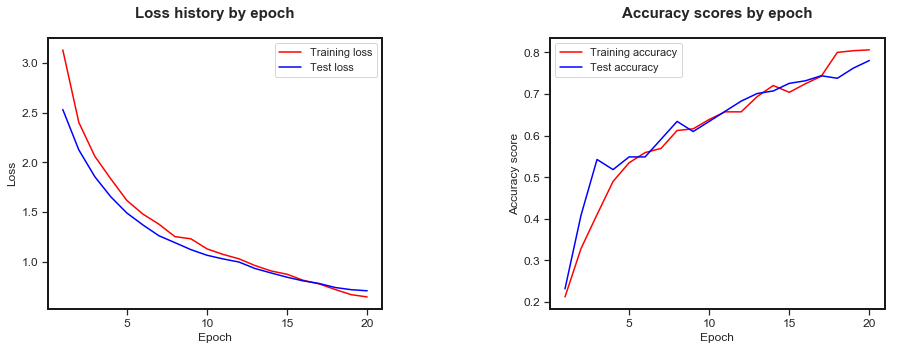

In [342]:
sns.set(style='ticks')
plt.subplots(figsize=(15,5))

##Visualise the loss history
ax = plt.subplot(121)

ax = sns.lineplot(epoch_count, training_loss, color='red')
ax = sns.lineplot(epoch_count, test_loss, color='blue')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss history by epoch', fontsize=15, weight='bold', y=1.05)
ax.legend(handles=ax.lines, labels=['Training loss', 'Test loss'])
plt.setp(ax.spines.values(), linewidth=2, color='k')
ax.tick_params(labelsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))


##Visualise the Accuracy scores
ax1 = plt.subplot(122)
ax1 = sns.lineplot(epoch_count, training_accuracy, color='red')
ax1 = sns.lineplot(epoch_count, test_accuracy, color='blue')
ax1.legend(handles=ax.lines, labels=['Training accuracy', 'Test accuracy'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy score')
ax1.set_title('Accuracy scores by epoch', fontsize=15, weight='bold', y=1.05)
plt.setp(ax1.spines.values(), linewidth=2, color='k')
ax1.tick_params(labelsize=12)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.subplots_adjust(wspace=0.5)
plt.show()
# plt.savefig('MLP_history_accuracy',dpi=400,bbox_inches='tight')

In [341]:
result = model.evaluate(x_test, y_test)
result

164/164 [==============================] - 0s 170us/step


[0.7048449850663906, 0.7804878048780488]

### MLP summary

The MLP overfits after about 12 epochs and the best performance has been c. 84% accuracy but the model overfit. Higher accuracy scores are achieved using tanh in combination with relu. The SGD metric yields very low results. Further training might provide a better model but the most stable result is c. 78%. The ensemble model using VotingClassifier has proved easier to train. Perhaps the MLP simply doesn't have enough data to predict adequately.

# 5. Concluding remarks

It has proved possible to train models to predict classes of small class size and with class imbalance. The fossil data can be cleaned and used effectvely. The results imply either that there is more contamination (caving) in the well than identified originally by the analysts who worked-up the data, or that analysts have misclassified/identified the age or stage of samples. 

Further work would be to check how the ZONES relate to one another and train those. Are they really distinct enough to be recognised by ML? Other models could be incorporated into an ensemble or more made of the Gradient Boosting models. The results are promising.

# 6. References

Albon, C. (2018). <i>Machine Learning with Python Cookbook</i>. pp.1-349. O'Reilly Media, In., Sebastopol, USA.

Cambridge Spark (https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f)

Chollet, F. (2018). *Deep Learning with Python*: pp: 1-361. Manning Publications Co., Staten Island, USA

Geron, A. (2017). <i>Hands-on Machine Learning with Scikit-Learn & TensorFlow</i>. pp.1-549. O'Reilly Media, In., Sebastopol, USA.

Gower, J.C. (1966). Some distance properties of latent root and vector methods used in multivariate analysis. <i>Biometrika</i>, <b>53</b>: 325-338.

Li, S. (2018) blog post https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

Oksanen, J., *et al.* (2018). vegan: Community Ecology Package. R package version 2.5-2. https://CRAN.R-project.org/package=vegan

Paliy, O. & Shankar, V. (2016). Application of multivariate statistical techniques in microbial ecology. <i>Molecular Ecology</i>, <b>25</b>: 1032-1057.

Petrou, T. (2017).<i> Pandas Cookbook</i>. pp. 1-513. Packt Publishing Ltd., Birmingham, UK. 

Ramette, A. (2007). Multivariate analyses in microbial ecology. <i>FEMS Microbial Ecology</i>, <b>62</b>: 142-160

Raschka, S. & Mirjalili, V. (2017). *Python Machine Learning (second edition)*.pp: 1-596. Packt Publishing Ltd., Birmingham UK.